In [3]:
import pandas as pd
df=pd.read_csv('diabetic_data.csv')

In [4]:
import numpy as np
df.replace({'?':np.nan},inplace=True)
df1=pd.DataFrame(df.isna().sum())
df1=df1.reset_index()
df1.columns=['Column_Names','Count_of_Nan_Values']
df2=df1[df1['Count_of_Nan_Values']!=0].sort_values(by=['Count_of_Nan_Values'],ascending=False)
df2['Percentage_of_NAN']=df2['Count_of_Nan_Values']/len(df)*100
print('The Nan Value columns with percentage are as follows')
print(df2)

The Nan Value columns with percentage are as follows
         Column_Names  Count_of_Nan_Values  Percentage_of_NAN
5              weight                98569          96.858479
11  medical_specialty                49949          49.082208
10         payer_code                40256          39.557416
2                race                 2273           2.233555
20             diag_3                 1423           1.398306
19             diag_2                  358           0.351787
18             diag_1                   21           0.020636


In [5]:
#Dropping columns with more than 40 percent null values
df.drop(['weight','payer_code','medical_specialty'],axis=1,inplace=True)
#Changing the readmitted column
df['readmitted'] = df['readmitted'].replace({'>30':1,'<30':1,'NO':0})
#Replacing Age with mean
df['age'] = df['age'].replace({'[70-80)': 75, '[60-70)': 65, '[50-60)': 55, '[80-90)': 85, '[40-50)': 45, '[30-40)': 35, '[90-100)': 95, '[20-30)': 25, '[10-20)': 15, '[0-10)': 5})

In [6]:
df_diabetes=df.copy()
df_diabetes.drop(columns=['encounter_id','patient_nbr'],axis=1,inplace=True)

In [7]:
imbalanced_data=['examide','metformin-rosiglitazone','metformin-pioglitazone','glimepiride-pioglitazone','glipizide-metformin','glyburide-metformin','citoglipton','tolazamide','troglitazone','miglitol','acarbose','tolbutamide','acetohexamide','chlorpropamide','nateglinide','repaglinide']
df_diabetes.drop(columns=imbalanced_data,inplace=True)

In [11]:
import swifter

In [12]:
#Label Encoding in data where there is a ordinality
from sklearn.preprocessing import LabelEncoder
ordinal_columns=['max_glu_serum', 'A1Cresult',
       'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed']
df_diabetes[['max_glu_serum', 'A1Cresult',
       'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed']] = df_diabetes[['max_glu_serum', 'A1Cresult',
       'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed']].swifter.apply(LabelEncoder().fit_transform)

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

In [13]:
df_diabetes = df_diabetes.drop(df_diabetes.loc[df_diabetes["gender"]=="Unknown/Invalid"].index, axis=0)

In [14]:
ordinal_columns=['gender','race']
one_hot = pd.get_dummies(df_diabetes[['gender','race']])
df_diabetes=pd.concat([df_diabetes,one_hot],axis=1)

In [15]:
df_diabetes.drop(columns=['diag_1','diag_2','diag_3','gender','race'],inplace=True)

In [16]:
df_diabetes_final=df_diabetes.copy()

In [17]:
df_diabetes_final.shape

(101763, 31)

# Scaling the Dataframe

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df=pd.DataFrame(df_diabetes_final)
scaler.fit(df)
diabetes_scaled=scaler.transform(df)
df_diabetes_scaled=pd.DataFrame(diabetes_scaled)
df_sample_scaled=df_diabetes_scaled.copy()
df_sample_scaled=df_sample_scaled.head(10)
#df_diabetes_scaled=df_diabetes_scaled.drop(index=index)
df_diabetes_scaled.shape

(101763, 31)

# Starting the code for GMM

In [126]:
def complex_euclidean_distance(u, v):
    return np.sqrt(np.sum(np.abs(u - v) ** 2))
def wcss_emm(input_dataframe,labels_array,no_of_clusters):
    from scipy.spatial.distance import cdist
    input_dataframe_clustered=input_dataframe.copy()
    input_dataframe_clustered['Labels']=labels_array
    new_centroids=input_dataframe_clustered.groupby('Labels').mean()
    new_centroids=new_centroids.T
    total_error=[]
    no_of_clusters_array=np.array(labels_array)
    no_of_clusters=np.unique(no_of_clusters_array)
    for cluster in no_of_clusters:
        df_data_label_cluster=input_dataframe_clustered[input_dataframe_clustered['Labels']==cluster]
        df_data_label_cluster=df_data_label_cluster.drop('Labels',axis=1)
        centroids=pd.DataFrame(new_centroids[cluster])
        euclidean_distance=cdist(df_data_label_cluster,centroids.T,metric=complex_euclidean_distance)
        total_error.append(sum(euclidean_distance))
    return round(float(''.join(map(str, sum(total_error)))),3)    

def silheoutte_score(input_dataframe,labels):
    from sklearn.metrics import silhouette_score
    sample_size=5000
    sample_indices=np.random.choice(input_dataframe.shape[0], size=sample_size, replace=False)
    sample_data = input_dataframe[subset_indices]
    silhouette_avg= silhouette_score(sample_data,labels[sample_indices], metric='cosine')
    return silhouette_avg

def Calinski_Harbaz_score(input_dataframe,labels):
    from sklearn.metrics import calinski_harabasz_score
    chs=calinski_harabasz_score(input_dataframe,labels)
    return chs

def davies_bouldin_score(input_dataframe,labels):
    from sklearn.metrics import davies_bouldin_score
    dbs=davies_bouldin_score(input_dataframe,labels)
    return dbs

In [127]:
from scipy.stats import multivariate_normal
import numpy as np

def initialization_of_GMM(input_dataframe,no_of_clusters):
    '''
    The function takes scaled dataframe as input and initializes the GMM means,Covariances,and Weights
    '''
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    # Randomly initialize means vector
    means_vector = input_dataframe_values[np.random.choice(input_dataframe_values.shape[0], no_of_clusters, replace=False), :]
    # Initialize covariance matrices for each cluster
    covariances_vector = np.array([np.eye(column)] * no_of_clusters)
    # Initialize weights from uniform distribution
    weights_vector = np.ones(no_of_clusters) / no_of_clusters
    return means_vector,covariances_vector,weights_vector
    
    
def fit_Guassian_mixture_models(input_dataframe,no_of_clusters,max_no_of_iterations,threshold):
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    means,covariances,weights=initialization_of_GMM(input_dataframe,no_of_clusters)
    iteration = 0
    previous_log_likelihood_scalar=0
    while iteration < max_no_of_iterations:
       
        new_log_likelihood = 0
        for index in range(no_of_clusters):
            try:
                epsilon_weight=1e-6
                cov_inv = np.linalg.pinv(covariances[index] + np.diag(np.ones(covariances[index].shape[0]) * epsilon_weight))
                new_log_likelihood=new_log_likelihood+weights[index]*multivariate_normal.logpdf(input_dataframe_values,means[index], cov_inv)
            except np.linalg.LinAlgError as e:
                continue
        new_log_likelihood_scalar=np.sum(new_log_likelihood)
        
        '''
        Calculating percentage change
        '''
        if np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))<threshold:
            print("The input Threshold was {}".format(threshold))
            print("The calculated threshold is {}".format(np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))))
            break
        #else:
            #print("The input Threshold was {}".format(threshold))
            #print("The calculated threshold is {}".format(np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))))
        previous_log_likelihood_scalar=new_log_likelihood_scalar
        posterior_probabilities = np.zeros((len(input_dataframe_values),no_of_clusters))
        for index in range(no_of_clusters):
            try:
                cov_inv = np.linalg.pinv(covariances[index],rcond=1e-10)
            except np.linalg.LinAlgError as e:
                continue
            try:
                posterior_probabilities[:,index] = weights[index] * multivariate_normal.pdf(input_dataframe_values, means[index], cov_inv)
            except np.linalg.LinAlgError as e:
                continue
        posterior_probabilities/=np.sum(posterior_probabilities, axis=1, keepdims=True)

        
        
        for j in range(no_of_clusters):
            weighted_sum = np.zeros((1, means.shape[1]))
            sum_posterior = 0.0
            for i in range(row):
                weighted_sum += posterior_probabilities[i][j] * input_dataframe_values[i]
                sum_posterior += posterior_probabilities[i][j]
            means[j] = weighted_sum/sum_posterior
            difference = input_dataframe_values - means[j]
            covariances[j] = np.dot((difference * posterior_probabilities[:, j][:, np.newaxis]).T, difference) / np.sum(posterior_probabilities[:, j])
            covariances[j] += np.diag(np.ones(column) * 1e-6)
            weights[j] = np.mean(posterior_probabilities[:, j])
        
        
        
        iteration += 1
        
    return means,posterior_probabilities

# Running the code Multiple Times

In [749]:
expectation_maximization_statistics=[]
for no_of_clusters in range(2,6):
    print(no_of_clusters)
    for no_of_experiments in range(1,21):
        print(no_of_experiments)
        means,posterior_probabilities=fit_Guassian_mixture_models(df_diabetes_scaled,no_of_clusters,100,1)
        cluster_labels_original=np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1))
        cluster_labels_array=np.unique(np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1)))
        list_of_clusters=np.array([i for i in range(0,no_of_clusters)])
        missing_clusters=set(list_of_clusters)-set(cluster_labels_array)
        for missing_value in missing_clusters:
            unique_values,value_counts=np.unique(cluster_labels_original,return_counts=True)
            values_to_replace=unique_values[value_counts > 1]
            value_to_replace=np.random.choice(values_to_replace)
            indices=np.where(cluster_labels_original==value_to_replace)[0]
            random_index=np.random.choice(indices)
            new_value=missing_value
            cluster_labels_original[random_index]=new_value
        cluster_labels_array=cluster_labels_original
        within_sum_of_square_error=wcss_emm(df_diabetes_scaled,cluster_labels_array,no_of_clusters)
        #silheoutte_score_value=silheoutte_score(df_diabetes_scaled,cluster_labels_array)
        #print("C2")
        Calinski_Harbaz_score_value=Calinski_Harbaz_score(df_diabetes_scaled,cluster_labels_array)
        dbs_value=davies_bouldin_score(df_diabetes_scaled,cluster_labels_array)
        expectation_maximization_statistics.append([no_of_clusters,no_of_experiments,within_sum_of_square_error,silheoutte_score_value,Calinski_Harbaz_score_value,dbs_value])
        print("Appended_to_dataframe")
expectation_maximization_statistics_df= pd.DataFrame(expectation_maximization_statistics,columns=['No_of_Clusters', 'Iteration Number', 'within_sum_of_square_error','silheoutte_score','Calinski_Harbaz_score','davies_bouldin_score'])

2
1
The input Threshold was 1
The calculated threshold is 0.6130093332051809
Appended_to_dataframe
2
The input Threshold was 1
The calculated threshold is 0.17770956688906173
Appended_to_dataframe
3
The input Threshold was 1
The calculated threshold is 0.4506007617769829
Appended_to_dataframe
4
The input Threshold was 1
The calculated threshold is 0.24977137254373138
Appended_to_dataframe
5
The input Threshold was 1
The calculated threshold is 0.9698093988347065
Appended_to_dataframe
6
The input Threshold was 1
The calculated threshold is 0.0463874804594611
Appended_to_dataframe
7
Appended_to_dataframe
8
The input Threshold was 1
The calculated threshold is 0.7743273530279646
Appended_to_dataframe
9
The input Threshold was 1
The calculated threshold is 0.31729188115081997
Appended_to_dataframe
10
The input Threshold was 1
The calculated threshold is 0.36967549275179074
Appended_to_dataframe
11
The input Threshold was 1
The calculated threshold is 0.30508351180696996
Appended_to_datafra

/tmp/ipykernel_19373/598162089.py:71: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.09719962291502679
Appended_to_dataframe
15
The input Threshold was 1
The calculated threshold is 0.6523323425229592
Appended_to_dataframe
16


/tmp/ipykernel_19373/598162089.py:71: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.710503145850835
Appended_to_dataframe
17
The input Threshold was 1
The calculated threshold is 0.128305340859788
Appended_to_dataframe
18
The input Threshold was 1
The calculated threshold is 0.1191368941742772
Appended_to_dataframe
19
The input Threshold was 1
The calculated threshold is 0.4619507618394298
Appended_to_dataframe
20
The input Threshold was 1
The calculated threshold is 0.9800185935347029
Appended_to_dataframe
5
1
The input Threshold was 1
The calculated threshold is 0.1667940831042949
Appended_to_dataframe
2
The input Threshold was 1
The calculated threshold is 0.6145293432094645
Appended_to_dataframe
3
The input Threshold was 1
The calculated threshold is 0.44979502769980034
Appended_to_dataframe
4
The input Threshold was 1
The calculated threshold is 0.390433975365651
Appended_to_dataframe
5
The input Threshold was 1
The calculated threshold is 0.618058635971764
Appended_to_dataframe
6
The input Threshold was 1
T

/tmp/ipykernel_19373/598162089.py:71: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.5199905632055868
Appended_to_dataframe
14
The input Threshold was 1
The calculated threshold is 0.5414820470067384
Appended_to_dataframe
15
The input Threshold was 1
The calculated threshold is 0.3553404271645779
Appended_to_dataframe
16
The input Threshold was 1
The calculated threshold is 0.03498594845622781
Appended_to_dataframe
17
The input Threshold was 1
The calculated threshold is 0.6238902187502446
Appended_to_dataframe
18
The input Threshold was 1
The calculated threshold is 0.5931582845721903
Appended_to_dataframe
19
The input Threshold was 1
The calculated threshold is 0.6595766187292817
Appended_to_dataframe
20
The input Threshold was 1
The calculated threshold is 0.0034394953636431966
Appended_to_dataframe


In [400]:
expectation_maximization_statistics_df_plot=expectation_maximization_statistics_df.groupby(['No_of_Clusters']).mean().reset_index()[['No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
expectation_maximization_statistics_df_plot

,No_of_Clusters,within_sum_of_square_error,Calinski_Harbaz_score,davies_bouldin_score
0,2,542138.69510,1779.449975,3.741253
1,3,540885.47425,1068.012618,2.841975
2,4,542365.77010,575.393772,2.522989
3,5,540111.12660,669.381561,2.401605


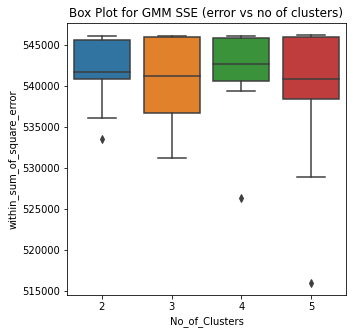

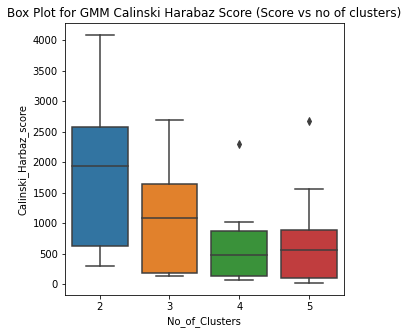

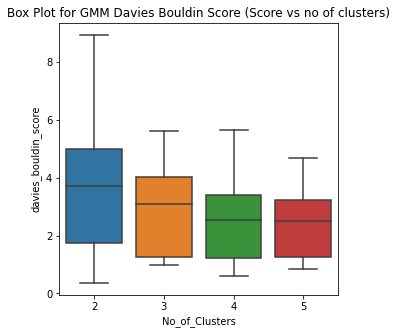

In [404]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
sns.boxplot(x=expectation_maximization_statistics_df['No_of_Clusters'],y=expectation_maximization_statistics_df['within_sum_of_square_error'])
plt.title('Box Plot for GMM SSE (error vs no of clusters)')
plt.show()
import seaborn as sns
plt.figure(figsize=(5,5))
sns.boxplot(x=expectation_maximization_statistics_df['No_of_Clusters'],y=expectation_maximization_statistics_df['Calinski_Harbaz_score'])
plt.title('Box Plot for GMM Calinski Harabaz Score (Score vs no of clusters)')
plt.show()
import seaborn as sns
plt.figure(figsize=(5,5))
sns.boxplot(x=expectation_maximization_statistics_df['No_of_Clusters'],y=expectation_maximization_statistics_df['davies_bouldin_score'])
plt.title('Box Plot for GMM Davies Bouldin Score (Score vs no of clusters)')
plt.show()

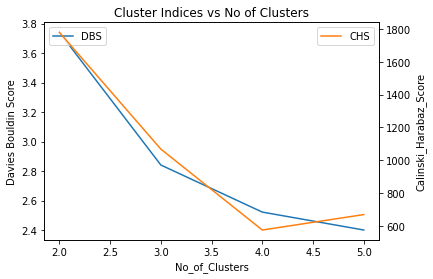

In [402]:
ax = expectation_maximization_statistics_df_plot.plot(x='No_of_Clusters', y='davies_bouldin_score')
ax2=expectation_maximization_statistics_df_plot.plot(x='No_of_Clusters', y='Calinski_Harbaz_score',secondary_y=True, ax=ax)
ax.set_xlabel('No_of_Clusters')
ax.set_ylabel('Davies Bouldin Score')
ax2.set_ylabel('Calinski_Harabaz_Score')
ax.set_title('Cluster Indices vs No of Clusters')
ax.legend(['DBS'], loc='upper left')
ax2.legend(['CHS'], loc='upper right')
plt.show()

# Initializing with K means ++

In [768]:
from scipy.stats import multivariate_normal
import numpy as np

def kmeans_pp_init(input_dataframe,no_of_clusters):
    from scipy.spatial.distance import cdist
    '''
    K-means++ is a variant of the K-means algorithm that aims to improve the initial centroids' selection 
    in the clustering process. 
    The standard K-means algorithm initializes the cluster centroids randomly, 
    which can lead to suboptimal clustering results, 
    especially if the dataset has complex or irregular structures.
    '''
    list_of_centroids=[]
    #Choosing the first centroid randomly
    centroid = input_dataframe.apply(lambda x: float(x.sample()))
    list_of_centroids.append(centroid)
    
    iterator=2
    while iterator<=no_of_clusters:
        '''
        Calculating the distances from the centroid to every data point
        If the no of centroids are more than 1 calculate the distance from every centroid and take minimum distance
        '''
        distances = np.array(np.amin(cdist(input_dataframe,list_of_centroids,metric='euclidean'),axis=1))
        #Next centroid will be selected with probability proportional to the distance
        
        probs = distances / np.sum(distances)
        '''
        Selection of the next centroids
        '''
        next_centroid = input_dataframe.iloc[np.random.choice(len(input_dataframe),p=probs)]
        list_of_centroids.append(next_centroid)
        iterator+=1
    
    centroid_df=pd.concat(list_of_centroids,axis=1,ignore_index=True)
    return centroid_df.T

def initialization_of_GMM_Kmeans(input_dataframe,no_of_clusters):
    '''
    The function takes scaled dataframe as input and initializes the GMM means,Covariances,and Weights
    '''
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    # Randomly initialize means vector
    means_vector = np.array(kmeans_pp_init(input_dataframe,no_of_clusters))
    # Initialize covariance matrices for each cluster
    covariances_vector = np.array([np.eye(column)] * no_of_clusters)
    # Initialize weights from uniform distribution
    weights_vector = np.ones(no_of_clusters) / no_of_clusters
    return means_vector,covariances_vector,weights_vector
    
    
def fit_Guassian_mixture_models_kmeans_plus_plus(input_dataframe,no_of_clusters,max_no_of_iterations,threshold):
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    means,covariances,weights=initialization_of_GMM_Kmeans(input_dataframe,no_of_clusters)
    iteration = 0
    previous_log_likelihood_scalar=0
    while iteration < max_no_of_iterations:
       
        new_log_likelihood = 0
        for index in range(no_of_clusters):
            try:
                epsilon_weight=1e-6
                cov_inv = np.linalg.pinv(covariances[index] + np.diag(np.ones(covariances[index].shape[0]) * epsilon_weight))
                new_log_likelihood=new_log_likelihood+weights[index]*multivariate_normal.logpdf(input_dataframe_values,means[index], cov_inv)
            except np.linalg.LinAlgError as e:
                continue
        new_log_likelihood_scalar=np.sum(new_log_likelihood)
        
        '''
        Calculating percentage change
        '''
        if np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))<threshold:
            print("The input Threshold was {}".format(threshold))
            print("The calculated threshold is {}".format(np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))))
            break
        #else:
            #print("The input Threshold was {}".format(threshold))
            #print("The calculated threshold is {}".format(np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))))
            
        
        previous_log_likelihood_scalar=new_log_likelihood_scalar
        
        posterior_probabilities = np.zeros((len(input_dataframe_values),no_of_clusters))
        for index in range(no_of_clusters):
            try:
                cov_inv = np.linalg.pinv(covariances[index],rcond=1e-10)
            except np.linalg.LinAlgError as e:
                continue
            try:
                posterior_probabilities[:,index] = weights[index] * multivariate_normal.pdf(input_dataframe_values, means[index], cov_inv)
            except np.linalg.LinAlgError as e:
                continue
        posterior_probabilities/=np.sum(posterior_probabilities, axis=1, keepdims=True)

        
        
        for j in range(no_of_clusters):
            weighted_sum = np.zeros((1, means.shape[1]))
            sum_posterior = 0.0
            for i in range(row):
                weighted_sum += posterior_probabilities[i][j] * input_dataframe_values[i]
                sum_posterior += posterior_probabilities[i][j]
            means[j] = weighted_sum/sum_posterior
            difference = input_dataframe_values - means[j]
            covariances[j] = np.dot((difference * posterior_probabilities[:, j][:, np.newaxis]).T, difference) / np.sum(posterior_probabilities[:, j])
            covariances[j] += np.diag(np.ones(column) * 1e-6)
            weights[j] = np.mean(posterior_probabilities[:, j])
        
        
        
        iteration += 1
        
    return means,posterior_probabilities

In [770]:
expectation_maximization_statistics_kmeans_plus_plus=[]
for no_of_clusters in range(2,6):
    print(no_of_clusters)
    for no_of_experiments in range(1,21):
        print(no_of_experiments)
        means,posterior_probabilities=fit_Guassian_mixture_models_kmeans_plus_plus(df_diabetes_scaled,no_of_clusters,100,1)
        cluster_labels_original=np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1))
        cluster_labels_array=np.unique(np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1)))
        list_of_clusters=np.array([i for i in range(0,no_of_clusters)])
        missing_clusters=set(list_of_clusters)-set(cluster_labels_array)
        for missing_value in missing_clusters:
            unique_values,value_counts=np.unique(cluster_labels_original,return_counts=True)
            values_to_replace=unique_values[value_counts > 1]
            value_to_replace=np.random.choice(values_to_replace)
            indices=np.where(cluster_labels_original==value_to_replace)[0]
            random_index=np.random.choice(indices)
            new_value=missing_value
            cluster_labels_original[random_index]=new_value
        cluster_labels_array=cluster_labels_original
        within_sum_of_square_error=wcss_emm(df_diabetes_scaled,cluster_labels_array,no_of_clusters)
        #silheoutte_score_value=silheoutte_score(df_diabetes_scaled,cluster_labels_array)
        #print("C2")
        Calinski_Harbaz_score_value=Calinski_Harbaz_score(df_diabetes_scaled,cluster_labels_array)
        dbs_value=davies_bouldin_score(df_diabetes_scaled,cluster_labels_array)
        expectation_maximization_statistics_kmeans_plus_plus.append([no_of_clusters,no_of_experiments,within_sum_of_square_error,silheoutte_score_value,Calinski_Harbaz_score_value,dbs_value])
        print("Appended_to_dataframe")
expectation_maximization_statistics_kmeans_plus_plus_df= pd.DataFrame(expectation_maximization_statistics_kmeans_plus_plus,columns=['No_of_Clusters', 'Iteration Number', 'within_sum_of_square_error','silheoutte_score','Calinski_Harbaz_score','davies_bouldin_score'])

2
1


/tmp/ipykernel_19373/1982634810.py:105: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.0
Appended_to_dataframe
2
The input Threshold was 1
The calculated threshold is 0.7266776646382723
Appended_to_dataframe
3
The input Threshold was 1
The calculated threshold is 0.08545603021926158
Appended_to_dataframe
4
The input Threshold was 1
The calculated threshold is 0.6078497419208025
Appended_to_dataframe
5
The input Threshold was 1
The calculated threshold is 0.8404338896526075
Appended_to_dataframe
6
The input Threshold was 1
The calculated threshold is 0.14401854475958023
Appended_to_dataframe
7
The input Threshold was 1
The calculated threshold is 0.7375345373965213
Appended_to_dataframe
8
The input Threshold was 1
The calculated threshold is 0.4053128731270189
Appended_to_dataframe
9
The input Threshold was 1
The calculated threshold is 0.972292374453261
Appended_to_dataframe
10
The input Threshold was 1
The calculated threshold is 0.6890503947471306
Appended_to_dataframe
11
The input Threshold was 1
The calculated t

/tmp/ipykernel_19373/1982634810.py:105: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.3151932342526784
Appended_to_dataframe
11
The input Threshold was 1
The calculated threshold is 0.1164968130528761
Appended_to_dataframe
12
The input Threshold was 1
The calculated threshold is 0.24965470150849142
Appended_to_dataframe
13
The input Threshold was 1
The calculated threshold is 0.8582783128018081
Appended_to_dataframe
14
The input Threshold was 1
The calculated threshold is 0.21703563552733593
Appended_to_dataframe
15
The input Threshold was 1
The calculated threshold is 0.6432851883191361
Appended_to_dataframe
16
The input Threshold was 1
The calculated threshold is 0.03894042523572356
Appended_to_dataframe
17
The input Threshold was 1
The calculated threshold is 0.5271482668209845
Appended_to_dataframe
18
The input Threshold was 1
The calculated threshold is 0.0921959869787786
Appended_to_dataframe
19
The input Threshold was 1
The calculated threshold is 0.25232270791608724
Appended_to_dataframe
20
The input Thresh

/tmp/ipykernel_19373/1982634810.py:105: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.450615348390082
Appended_to_dataframe
14
The input Threshold was 1
The calculated threshold is 0.7819398023789176
Appended_to_dataframe
15
The input Threshold was 1
The calculated threshold is 0.745838555915008
Appended_to_dataframe
16
The input Threshold was 1
The calculated threshold is 0.08736872400441986
Appended_to_dataframe
17
The input Threshold was 1
The calculated threshold is 0.5562352469727772
Appended_to_dataframe
18
The input Threshold was 1
The calculated threshold is 0.9360425694804981
Appended_to_dataframe
19
The input Threshold was 1
The calculated threshold is 0.6313959940012744
Appended_to_dataframe
20
The input Threshold was 1
The calculated threshold is 0.3427167741800528
Appended_to_dataframe


In [396]:
expectation_maximization_statistics_kmeans_plus_plus_df_plot=expectation_maximization_statistics_kmeans_plus_plus_df.groupby(['No_of_Clusters']).mean().reset_index()[['No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]

# Comparing GMM and GMM++

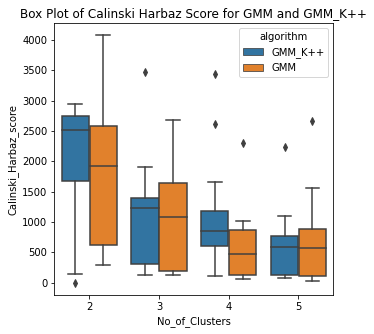

In [446]:
import seaborn as sns
expectation_maximization_statistics_kmeans_plus_plus_df['algorithm']='GMM_K++'
expectation_maximization_statistics_df['algorithm']='GMM'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_kmeans_plus_plus_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='Calinski_Harbaz_score', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['GMM_K++','GMM'])],ax=ax);
plt.title('Box Plot of Calinski Harbaz Score for GMM and GMM_K++')
plt.show()

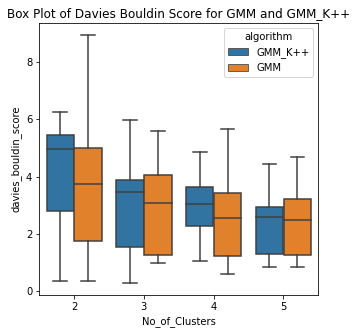

In [444]:
import seaborn as sns
expectation_maximization_statistics_kmeans_plus_plus_df['algorithm']='GMM_K++'
expectation_maximization_statistics_df['algorithm']='GMM'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_kmeans_plus_plus_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='davies_bouldin_score', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['GMM_K++','GMM'])],ax=ax);
plt.title('Box Plot of Davies Bouldin Score for GMM and GMM_K++')
plt.show()

In [ ]:
import seaborn as sns
expectation_maximization_statistics_kmeans_plus_plus_df['algorithm']='GMM_K++'
expectation_maximization_statistics_df['algorithm']='GMM'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_kmeans_plus_plus_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='within_sum_of_square_error', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['GMM_K++','GMM'])],ax=ax);
plt.title('Box Plot of SSE for GMM and GMM_K++')
plt.show()

# Running k means ++ on dataset

In [454]:
df_diabetes_scaled.columns=df_diabetes.columns

In [455]:
error_values_kmeans_plus_plus_alone=[]
for no_of_clusters in range(2,6):
    print(no_of_clusters)
    for no_of_experiments in range(1,21):
        print(no_of_experiments)
        final_centroids,sum_of_squared_error,sil_score,chs_score,dbs_score,run_time,same_centroid=kmeans_plus_plus(df_diabetes_scaled,no_of_clusters,10,100)
        error_values_kmeans_plus_plus_alone.append([no_of_clusters,no_of_experiments,sum_of_squared_error,sil_score,chs_score,dbs_score,run_time])
error_values_kmeans_plus_plus_alone_df= pd.DataFrame(error_values_kmeans_plus_plus_alone,columns=['No_of_Clusters', 'Iteration Number','within_sum_of_square_error','Silheoutte_Score','Calinski_Harbaz_score','davies_bouldin_score','run_time'])  

2
1


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.027661108244967
2


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.290179617235085
3


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.1197223900853075
4


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.14403150903134
5


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.16587811831546
6


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.941524211150632
7


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.8428384327903995
8


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.957404200397479
9


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.0101545897246575
10


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.889712614040437
11


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.744975972075062
12


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 7.853786535008493
13


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.979194729856646
14


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.787068393537972
15


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.102971901091846
16


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.254822405741229
17


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.498692162716025
18


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.9524812061413375
19


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.016090881092174
20


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.360112824282797
3
1


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8560267448158707
2


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.5734075093488777
3


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.3567908721341615
4


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.167173846767414
5


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.3951654945641514
6


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.950957687117515
7


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.17788362175178
8


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.4132287678864297
9


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.150040668954724
10


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.7748438141550436
11


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.083560673833528
12


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.5020769234034006
13


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8253885669719483
14


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.500274705587861
15


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.904237752598814
16


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.871848069269184
17


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.494269945211117
18


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8703839897384165
19


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.581390779187867
20


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.738819688915239
4
1


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.9325372086517625
2


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.314300356852269
3


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9801147488318325
4


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 2.703123704145921
5


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.774800606740297
6


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.4182697553981187
7


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.019764060831484
8


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.468461829516644
9


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.333369855820802
10


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.988196513381895
11


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.715659701151183
12


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.321714407042583
13


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.2752304494090323
14


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.530352649017984
15


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.793033264307956
16


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.2984896976946634
17


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.6059215163883525
18


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.1755232738170855
19


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.725712302336033
20


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.953347080447351
5
1


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8130838367571607
2


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.932211949551575
3


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.6854373740518085
4


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8340818781146253
5


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.5847816366631555
6


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.350708043254
7


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.631848487637785
8


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.586722022797892
9


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.1254902992851616
10


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.7703368832691866
11


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8374627231882323
12


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 2.813377604975524
13


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.029962053024656
14


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9175069446344573
15


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.365900758584099
16


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.2875402280169013
17


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.316403633537914
18


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.407090880995026
19


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.249234816361067
20


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.4470076198726387


In [458]:
error_values_kmeans_plus_plus_alone_df.head(1)

,No_of_Clusters,Iteration Number,within_sum_of_square_error,Silheoutte_Score,Calinski_Harbaz_score,davies_bouldin_score,run_time,algorithm
0,2,1,526546.274,0,3245.356811,5.284691,0.922614,K++


# Comparing K means ++ and GMM++

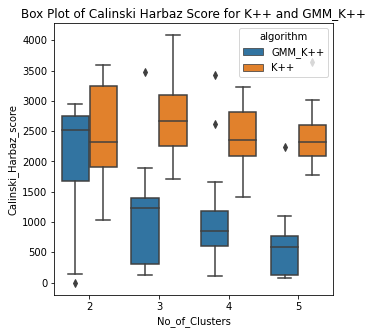

In [457]:
import seaborn as sns
expectation_maximization_statistics_kmeans_plus_plus_df['algorithm']='GMM_K++'
error_values_kmeans_plus_plus_alone_df['algorithm']='K++'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_kmeans_plus_plus_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_plus_plus_alone_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='Calinski_Harbaz_score', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['GMM_K++','K++'])],ax=ax);
plt.title('Box Plot of Calinski Harbaz Score for K++ and GMM_K++')
plt.show()

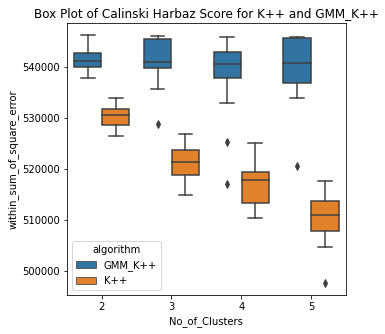

In [459]:
import seaborn as sns
expectation_maximization_statistics_kmeans_plus_plus_df['algorithm']='GMM_K++'
error_values_kmeans_plus_plus_alone_df['algorithm']='K++'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_kmeans_plus_plus_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_plus_plus_alone_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='within_sum_of_square_error', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['GMM_K++','K++'])],ax=ax);
plt.title('Box Plot of Within Sum of Square Error for K++ and GMM_K++')
plt.show()

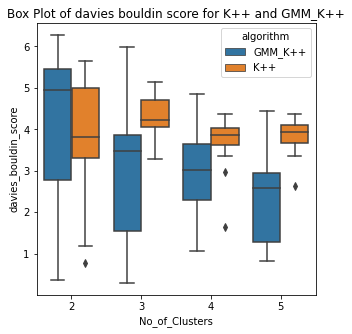

In [460]:
import seaborn as sns
expectation_maximization_statistics_kmeans_plus_plus_df['algorithm']='GMM_K++'
error_values_kmeans_plus_plus_alone_df['algorithm']='K++'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_kmeans_plus_plus_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_plus_plus_alone_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='davies_bouldin_score', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['GMM_K++','K++'])],ax=ax);
plt.title('Box Plot of davies bouldin score for K++ and GMM_K++')
plt.show()

# Running K means on dataset without K++

In [463]:
import numpy as np
import swifter
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
import time
def get_random_centroids(input_dataframe,no_of_clusters):
    list_of_centroids = []
    
    for cluster in range(no_of_clusters):
        random_centroid = input_dataframe.swifter.apply(lambda x:float(x.sample()))
        list_of_centroids.append(random_centroid)
    
    centroid_df=pd.concat(list_of_centroids,axis=1)
    
    centroid_df.index.name='Cluster_Assigned'
    
    return centroid_df


def get_labels(input_dataframe,centroid_df):
    euclidean_distances = centroid_df.swifter.apply(lambda x: np.sqrt(((input_dataframe - x) ** 2).sum(axis=1)))
    return pd.DataFrame(euclidean_distances.idxmin(axis=1))

        
def get_new_centroids(df_clustered_label,input_dataframe):
    df_original_label_join=input_dataframe.join(df_clustered_label)
    df_original_label_join.rename(columns={0:'Cluster_Assigned'},inplace=True)
    new_centroids=df_original_label_join.groupby('Cluster_Assigned').mean()
    return new_centroids.T


def kmeans_llyod(input_dataframe,no_of_clusters,threshold,no_of_iterations):
    start_time=time.time()
    iteration=0
    initial_centroid=get_random_centroids(input_dataframe,no_of_clusters)
    same_centroid=initial_centroid
    initial_centroid_column_list=initial_centroid.columns.to_list()
    
    while True:
        
        df_cluster_label=get_labels(input_dataframe,initial_centroid)
        df_new_centroids=get_new_centroids(df_cluster_label,input_dataframe)
        new_list_of_columns=df_new_centroids.columns.to_list()
        initial_set_columns = set(initial_centroid_column_list)
        new_set_columns = set(new_list_of_columns)
        missing_columns = initial_set_columns - new_set_columns
        for col in missing_columns:
            df_new_centroids[col]=initial_centroid[col]
        
        from scipy.spatial.distance import euclidean
        scalar_product = [euclidean(initial_centroid[col],df_new_centroids[col]) for col in initial_centroid.columns]
        threshold_calculated=float(sum(scalar_product))/no_of_clusters
        
        iteration+=1
        
        if threshold_calculated<threshold:
            print("The input Threshold was {}".format(threshold))
            print("The calculated threshold is {}".format(threshold_calculated))
        
        if iteration>no_of_iterations:
            print("Limit for iterations has exceeded")
        
        if threshold_calculated<threshold or iteration>no_of_iterations:
            sum_of_square_error=sum_of_square_error_function(df_cluster_label,input_dataframe,df_new_centroids,no_of_clusters)
            df_cluster_label_copy=df_cluster_label.copy()
            df_cluster_label_copy.rename(columns={0:'Cluster_Assigned'},inplace=True)
            labels=df_cluster_label_copy['Cluster_Assigned'].to_list()
            #silheoutte_score=silheoutte_score_Kmeans(input_dataframe,labels)
            silheoutte_score=0
            chs_score=Calinski_Harbaz_score_Kmeans(input_dataframe,labels)
            dbs_score=davies_bouldin_score(input_dataframe,labels)
            end_time=time.time()
            return df_new_centroids,sum_of_square_error,silheoutte_score,chs_score,dbs_score,end_time-start_time,same_centroid
            break
        else:
            initial_centroid= df_new_centroids
        

def sum_of_square_error_function(df_cluster_label,input_dataframe,df_new_centroids,no_of_clusters):
    df_data_label=input_dataframe.join(df_cluster_label)
    df_data_label.rename(columns={0:'Cluster_Assigned'},inplace=True)
    total_error=[]
    for cluster in range(no_of_clusters):
        df_data_label_cluster=df_data_label[df_data_label['Cluster_Assigned']==cluster]
        df_data_label_cluster=df_data_label_cluster.drop('Cluster_Assigned',axis=1)
        centroids=pd.DataFrame(df_new_centroids[cluster])
        euclidean_distance=cdist(df_data_label_cluster,centroids.T,metric='euclidean')
        total_error.append(sum(euclidean_distance))
    return round(float(''.join(map(str, sum(total_error)))),3)

def silheoutte_score_Kmeans(input_dataframe,labels):
    from sklearn.metrics import silhouette_score
    silhouette_avg = silhouette_score(input_dataframe, labels)
    return silhouette_avg

def Calinski_Harbaz_score_Kmeans(input_dataframe,labels):
    from sklearn.metrics import calinski_harabasz_score
    chs=calinski_harabasz_score(input_dataframe,labels)
    return chs


def davies_bouldin_score(input_dataframe,labels):
    from sklearn.metrics import davies_bouldin_score
    dbs=davies_bouldin_score(input_dataframe,labels)
    return dbs

In [466]:
error_values_kmeans_alone=[]
for no_of_clusters in range(2,6):
    print(no_of_clusters)
    for no_of_experiments in range(1,21):
        print(no_of_experiments)
        final_centroids,sum_of_squared_error,sil_score,chs_score,dbs_score,run_time,same_centroid=kmeans_llyod(df_diabetes_scaled,no_of_clusters,10,100)
        error_values_kmeans_alone.append([no_of_clusters,no_of_experiments,sum_of_squared_error,sil_score,chs_score,dbs_score,run_time])
error_values_kmeans_alone_df= pd.DataFrame(error_values_kmeans_alone,columns=['No_of_Clusters', 'Iteration Number','within_sum_of_square_error','Silheoutte_Score','Calinski_Harbaz_score','davies_bouldin_score','run_time'])  

2
1


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.046986845258697
2


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.7875267013813962
3


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.146483505094152
4


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.877816669418774
5


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.604389466905961
6


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.806208168576074
7


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.332806498076028
8


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.062187126488064
9


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.901446231801813
10


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.664756017512799
11


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.394967458451186
12


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.306276345001293
13


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.336454612064811
14


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.749406707078794
15


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.966393016789528
16


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.003068944628128
17


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.791192883240468
18


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.335729237085122
19


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.317365428796995
20


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8075701160445696
3
1


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.211577101859383
2


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.741162896401385
3


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.396897299247499
4


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.24384495071341
5


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.449648090249064
6


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.389651645630544
7


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.15732770495399
8


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.023699894830127
9


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.800903277283869
10


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.715167271292774
11


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.243276205260127
12


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.736086245727542
13


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.428910961563111
14


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.889214619654331
15


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8444595392383913
16


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.381555885862094
17


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.869391319524786
18


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.91352082066922
19


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9199687710205766
20


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.926905133392045
4
1


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.006848334826328
2


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.62631019990178
3


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.562371394017413
4


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.0024060510423625
5


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.698926398240148
6


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.5362688313726025
7


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.94977070122898
8


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.632566893101556
9


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.903999455292309
10


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8006112380797803
11


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.496395658106778
12


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.4356315812274554
13


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8081508610765264
14


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8784117867451133
15


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.0876392110704085
16


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.1554726735301735
17


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.706602355763108
18


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9886019496773892
19


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.643644355675031
20


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.22180142751549
5
1


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.216769682951095
2


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.095788687593467
3


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.510146848603246
4


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.26995149841696
5


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.016411957650556
6


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.188969860499972
7


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.417470848174058
8


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.66462384853927
9


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.7213429614543427
10


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.6711371872062175
11


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8558293957457153
12


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.226864813833549
13


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.222506770737814
14


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.630751633801105
15


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.062099186662413
16


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8815986188884906
17


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.715276449229907
18


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.5735128707202195
19


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.857922796763975
20


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.0090590667184536


# Comparing everything K means,K means ++,EM,EM++

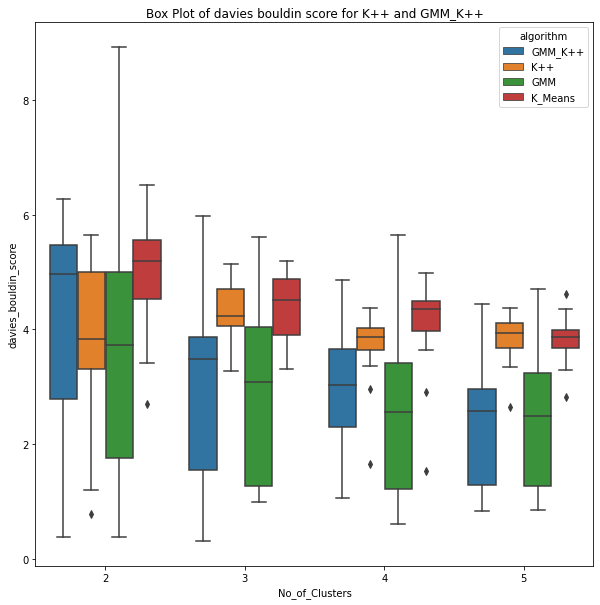

In [468]:
import seaborn as sns
expectation_maximization_statistics_kmeans_plus_plus_df['algorithm']='GMM_K++'
error_values_kmeans_plus_plus_alone_df['algorithm']='K++'
expectation_maximization_statistics_df['algorithm']='GMM'
error_values_kmeans_alone_df['algorithm']='K_Means'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_kmeans_plus_plus_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_plus_plus_alone_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_alone_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]                         
],ignore_index=True)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='No_of_Clusters', y='davies_bouldin_score', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['GMM_K++','K++','GMM','K_Means'])],ax=ax);
plt.title('Box Plot of davies bouldin score for K++ and GMM_K++')
plt.show()

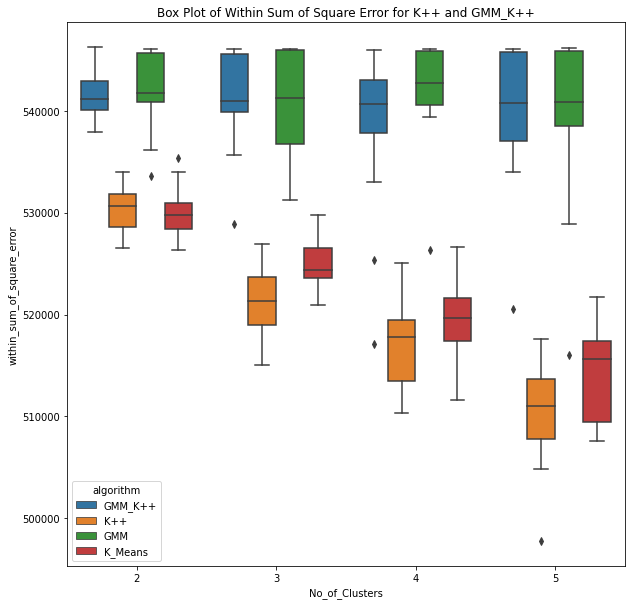

In [470]:
import seaborn as sns
expectation_maximization_statistics_kmeans_plus_plus_df['algorithm']='GMM_K++'
error_values_kmeans_plus_plus_alone_df['algorithm']='K++'
expectation_maximization_statistics_df['algorithm']='GMM'
error_values_kmeans_alone_df['algorithm']='K_Means'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_kmeans_plus_plus_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_plus_plus_alone_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_alone_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]                         
],ignore_index=True)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='No_of_Clusters', y='within_sum_of_square_error', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['GMM_K++','K++','GMM','K_Means'])],ax=ax);
plt.title('Box Plot of Within Sum of Square Error for K++ and GMM_K++')
plt.show()

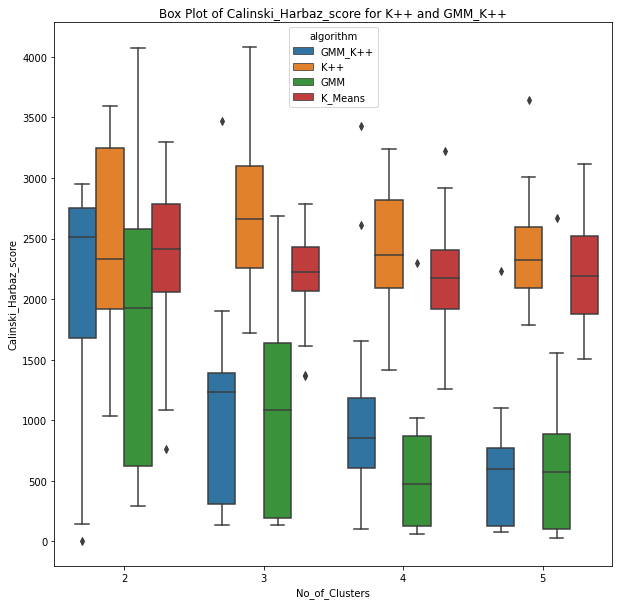

In [471]:
import seaborn as sns
expectation_maximization_statistics_kmeans_plus_plus_df['algorithm']='GMM_K++'
error_values_kmeans_plus_plus_alone_df['algorithm']='K++'
expectation_maximization_statistics_df['algorithm']='GMM'
error_values_kmeans_alone_df['algorithm']='K_Means'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_kmeans_plus_plus_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_plus_plus_alone_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_alone_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]                         
],ignore_index=True)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='No_of_Clusters', y='Calinski_Harbaz_score', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['GMM_K++','K++','GMM','K_Means'])],ax=ax);
plt.title('Box Plot of Calinski_Harbaz_score for K++ and GMM_K++')
plt.show()

# Performing PCA on data

In [417]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

def covariance(input_dataframe):
    '''
    This function takse input as a standardized dataframe
    '''
    input_dataframe_mean = input_dataframe.swifter.apply(np.mean, axis=0)
    input_dataframe_centered= input_dataframe-input_dataframe_mean
    with tqdm(total=input_dataframe.shape[1], desc="Calculating Covariance Matrix") as pbar:
        cov_matrix=np.cov(input_dataframe.T)
        pbar.update()
    return cov_matrix,input_dataframe_centered

def principal_component_analysis(input_dataframe):
    '''
    This function takes input_dataframe,stadndardizes it and number of components as the number of components required by PC
    '''
    scaler = StandardScaler()
    input_dataframe_scaled =pd.DataFrame(scaler.fit_transform(input_dataframe))
    #Calling the covriance function
    covariance_matrix,input_dataframe_centered=covariance(input_dataframe_scaled)
    #Calculates Covariance Matirx
    eigen_values,eigen_vectors=np.linalg.eig(covariance_matrix)
    #Calculates Eigen Values and Eigen Vectors
    sorted_indices=np.argsort(eigen_values)
    #Sort the elements in descending order
    sorted_indices=sorted_indices[::-1]
    
    
    explained_variances = eigen_values / np.sum(eigen_values)
    
    variance_explained_ratios = pd.DataFrame(explained_variances[sorted_indices], columns=["variance_explained_ratio"])
    variance_explained_ratios["cumulative_variance_explained_ratio"] = variance_explained_ratios["variance_explained_ratio"].cumsum()
    
    #Find the number of components that explain 90% of variance
    number_of_components = variance_explained_ratios["cumulative_variance_explained_ratio"][variance_explained_ratios["cumulative_variance_explained_ratio"] <= 0.90].count() + 1
    
    print("Number of Principal components explain 90% of variance are {}".format(number_of_components))
    
    
    
    
    #Taking Top Eigen Values and Top Eigen Vectors
    top_eigen_values_indices=sorted_indices[:number_of_components]
    top_eigen_vectors=eigen_vectors[:,top_eigen_values_indices]
    
     #Variance Calculations Plot
    explained_variances = eigen_values/np.sum(eigen_values)
    variance_explained = pd.DataFrame(eigen_values[top_eigen_values_indices] / sum(eigen_values))
    variance_explained['PC_Feature']=top_eigen_values_indices
    variance_explained_plot=pd.Series(eigen_values[top_eigen_values_indices] / sum(eigen_values))
    
    
    #Cumulative Variance Plot
    cumulative_variance_explained = np.cumsum(variance_explained_plot)
    cumulative_variance_explained_plot = pd.Series(cumulative_variance_explained)
    
    
    
    #Projecting Principal Components 
    principal_components=input_dataframe_centered.dot(top_eigen_vectors)
    principal_components.columns=[f'PC{i+1}' for i in range(number_of_components)]
    
    
   
    
    #Calculate the loadings
    loadings = pd.DataFrame(top_eigen_vectors,index=input_dataframe.columns)
    
    df_principal_components=pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(number_of_components)])
    #PLotting the graph 
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(np.arange(1, number_of_components+1),variance_explained_plot, 'o-')
    ax[0].set_xlabel('Principal Component')
    ax[0].set_ylabel('Proportion of Variance Explained')
    ax[0].set_title('Scree Plot')
    
    
    ax[1].plot(np.arange(1, number_of_components+1),cumulative_variance_explained_plot, 'o-')
    ax[1].set_xlabel('Principal Component')
    ax[1].set_ylabel('Cumulative Proportion of Variance Explained')
    ax[1].set_title('Cumulative Scree Plot')
    plt.tight_layout()
    plt.show()
    
    #Correlation between PC1 and PC2
    
    plt.scatter(principal_components['PC1'], principal_components['PC2'])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Scatter plot of PC1 against PC2')
    plt.show()
    
    principal_components_temp=principal_components[['PC1','PC2']]
    corr_matrix = principal_components_temp.corr()
    print('Correlation matrix:')
    print(corr_matrix)
    
    total_variance_explained=cumulative_variance_explained_plot[1]
    print("The total variance explained by first two PC's is {}".format(total_variance_explained))

    return variance_explained,loadings,principal_components,cumulative_variance_explained
    

Calculating Covariance Matrix:   3%|▎         | 1/31 [00:00<00:00, 36.66it/s]


Number of Principal components explain 90% of variance are 24


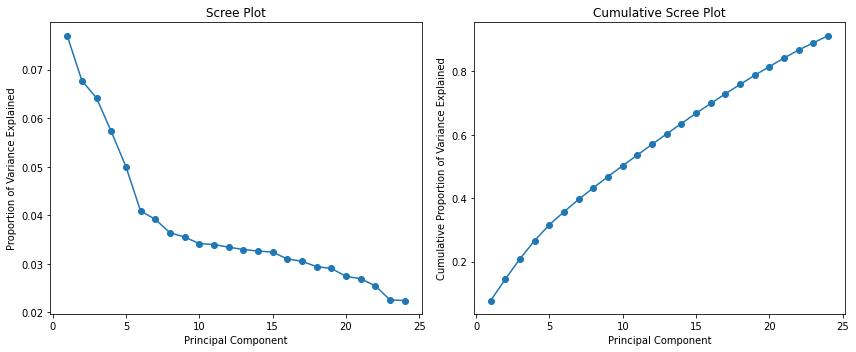

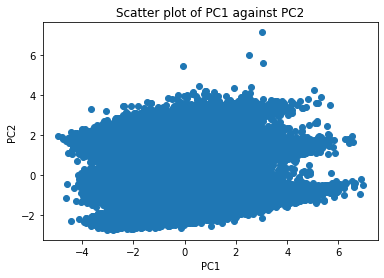

Correlation matrix:
              PC1           PC2
PC1  1.000000e+00 -3.559340e-16
PC2 -3.559340e-16  1.000000e+00
The total variance explained by first two PC's is 0.1447485743111172


In [418]:
variance_explained,loadings,principal_components,cumulative_variance_explained=principal_component_analysis(df_diabetes_scaled)

# Running EM Algorithm on reduced dataset with K means plus plus init

In [801]:
expectation_maximization_statistics_kmeans_plus_plus_pca=[]
for no_of_clusters in range(2,6):
    print(no_of_clusters)
    for no_of_experiments in range(1,21):
        print(no_of_experiments)
        means,posterior_probabilities=fit_Guassian_mixture_models_kmeans_plus_plus(principal_components,no_of_clusters,100,1)
        cluster_labels_original=np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1))
        cluster_labels_array=np.unique(np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1)))
        list_of_clusters=np.array([i for i in range(0,no_of_clusters)])
        missing_clusters=set(list_of_clusters)-set(cluster_labels_array)
        for missing_value in missing_clusters:
            unique_values,value_counts=np.unique(cluster_labels_original,return_counts=True)
            values_to_replace=unique_values[value_counts > 1]
            value_to_replace=np.random.choice(values_to_replace)
            indices=np.where(cluster_labels_original==value_to_replace)[0]
            if len(indices)==0:
                indices=[0]
            random_index=np.random.choice(indices)
            new_value=missing_value
            cluster_labels_original[random_index]=new_value
        cluster_labels_array=cluster_labels_original
        try:
            within_sum_of_square_error=wcss_emm(principal_components,cluster_labels_array,no_of_clusters)
        except KeyError as e:
            continue
        Calinski_Harbaz_score_value=Calinski_Harbaz_score(principal_components,cluster_labels_array)
        dbs_value=davies_bouldin_score(principal_components,cluster_labels_array)
        expectation_maximization_statistics_kmeans_plus_plus_pca.append([no_of_clusters,no_of_experiments,within_sum_of_square_error,silheoutte_score_value,Calinski_Harbaz_score_value,dbs_value])
        print("Appended_to_dataframe")
expectation_maximization_statistics_kmeans_plus_plus_pca_df= pd.DataFrame(expectation_maximization_statistics_kmeans_plus_plus_pca,columns=['No_of_Clusters', 'Iteration Number', 'within_sum_of_square_error','silheoutte_score','Calinski_Harbaz_score','davies_bouldin_score'])

2
1
The input Threshold was 1
The calculated threshold is 0.6133481134824815
Appended_to_dataframe
2
The input Threshold was 1
The calculated threshold is 0.454588724404762
Appended_to_dataframe
3


/tmp/ipykernel_19373/1982634810.py:95: RuntimeWarning: invalid value encountered in divide
  posterior_probabilities/=np.sum(posterior_probabilities, axis=1, keepdims=True)
/tmp/ipykernel_19373/1982634810.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  if np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))<threshold:
/tmp/ipykernel_19373/1982634810.py:74: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))<threshold:


4


/tmp/ipykernel_19373/1982634810.py:95: RuntimeWarning: invalid value encountered in divide
  posterior_probabilities/=np.sum(posterior_probabilities, axis=1, keepdims=True)
/tmp/ipykernel_19373/1982634810.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  if np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))<threshold:
/tmp/ipykernel_19373/1982634810.py:74: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))<threshold:


5
The input Threshold was 1
The calculated threshold is 0.3152364027986296
Appended_to_dataframe
6
The input Threshold was 1
The calculated threshold is 0.748799278319796
Appended_to_dataframe
7
The input Threshold was 1
The calculated threshold is 0.8145144113259397
Appended_to_dataframe
8
The input Threshold was 1
The calculated threshold is 0.9179696520049552
Appended_to_dataframe
9
The input Threshold was 1
The calculated threshold is 0.023241068871037076
Appended_to_dataframe
10
The input Threshold was 1
The calculated threshold is 0.05126065187458394
Appended_to_dataframe
11
Appended_to_dataframe
12
The input Threshold was 1
The calculated threshold is 0.11129464616138976
Appended_to_dataframe
13
The input Threshold was 1
The calculated threshold is 0.24332931156515306
Appended_to_dataframe
14
The input Threshold was 1
The calculated threshold is 0.9214639859138816
Appended_to_dataframe
15
The input Threshold was 1
The calculated threshold is 0.9663568842891876
Appended_to_datafr

/tmp/ipykernel_19373/1982634810.py:95: RuntimeWarning: invalid value encountered in divide
  posterior_probabilities/=np.sum(posterior_probabilities, axis=1, keepdims=True)
/tmp/ipykernel_19373/1982634810.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  if np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))<threshold:
/tmp/ipykernel_19373/1982634810.py:74: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))<threshold:


18


/tmp/ipykernel_19373/1982634810.py:95: RuntimeWarning: invalid value encountered in divide
  posterior_probabilities/=np.sum(posterior_probabilities, axis=1, keepdims=True)
/tmp/ipykernel_19373/1982634810.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  if np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))<threshold:
/tmp/ipykernel_19373/1982634810.py:74: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))<threshold:


19
The input Threshold was 1
The calculated threshold is 0.036038579895372104
Appended_to_dataframe
20
The input Threshold was 1
The calculated threshold is 0.9286145380539522
Appended_to_dataframe
3
1


/tmp/ipykernel_19373/1982634810.py:105: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.2258266894254854
Appended_to_dataframe
2
Appended_to_dataframe
3
The input Threshold was 1
The calculated threshold is 0.2362845965513756
Appended_to_dataframe
4
The input Threshold was 1
The calculated threshold is 0.5636867591668786
Appended_to_dataframe
5
The input Threshold was 1
The calculated threshold is 0.02119336196249674
Appended_to_dataframe
6
The input Threshold was 1
The calculated threshold is 0.09996365466746097
Appended_to_dataframe
7
The input Threshold was 1
The calculated threshold is 0.3087659731180367
Appended_to_dataframe
8
The input Threshold was 1
The calculated threshold is 0.2508682671484539
Appended_to_dataframe
9
The input Threshold was 1
The calculated threshold is 0.15443834673932905
Appended_to_dataframe
10
The input Threshold was 1
The calculated threshold is 0.862654448642703
Appended_to_dataframe
11
The input Threshold was 1
The calculated threshold is 0.9654986864272846
Appended_to_dataframe
12
T

/tmp/ipykernel_19373/1982634810.py:105: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


Appended_to_dataframe
13
The input Threshold was 1
The calculated threshold is 0.11548789914539848
Appended_to_dataframe
14
The input Threshold was 1
The calculated threshold is 0.6387173961328501
Appended_to_dataframe
15
The input Threshold was 1
The calculated threshold is 0.10293378769033862
Appended_to_dataframe
16
The input Threshold was 1
The calculated threshold is 0.9238086650215509
Appended_to_dataframe
17
The input Threshold was 1
The calculated threshold is 0.27452689081879805
Appended_to_dataframe
18
The input Threshold was 1
The calculated threshold is 0.634587968597545
Appended_to_dataframe
19
The input Threshold was 1
The calculated threshold is 0.6158974900669025
Appended_to_dataframe
20


/tmp/ipykernel_19373/1982634810.py:105: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.9028276281783246
Appended_to_dataframe
5
1
The input Threshold was 1
The calculated threshold is 0.992925407511488
Appended_to_dataframe
2
The input Threshold was 1
The calculated threshold is 0.9562088185922406
Appended_to_dataframe
3
The input Threshold was 1
The calculated threshold is 0.7455811794394862
Appended_to_dataframe
4
The input Threshold was 1
The calculated threshold is 0.10465609823929174
Appended_to_dataframe
5
The input Threshold was 1
The calculated threshold is 0.5828945814485879
Appended_to_dataframe
6
The input Threshold was 1
The calculated threshold is 0.8365276108309391
Appended_to_dataframe
7
The input Threshold was 1
The calculated threshold is 0.1315157911235446
Appended_to_dataframe
8
The input Threshold was 1
The calculated threshold is 0.20406506636657767
Appended_to_dataframe
9
The input Threshold was 1
The calculated threshold is 0.35052928420690127
Appended_to_dataframe
10
The input Threshold was 1

/tmp/ipykernel_19373/1982634810.py:105: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.6008377075310528
Appended_to_dataframe
14
The input Threshold was 1
The calculated threshold is 0.510213175829099
Appended_to_dataframe
15
The input Threshold was 1
The calculated threshold is 0.647240907159051
Appended_to_dataframe
16
The input Threshold was 1
The calculated threshold is 0.004812490539316384
Appended_to_dataframe
17
The input Threshold was 1
The calculated threshold is 0.31003886889098053
Appended_to_dataframe
18
The input Threshold was 1
The calculated threshold is 0.6671403823216285
Appended_to_dataframe
19
The input Threshold was 1
The calculated threshold is 0.1944867408071163
Appended_to_dataframe
20
The input Threshold was 1
The calculated threshold is 0.38630846539523256
Appended_to_dataframe


In [440]:
expectation_maximization_statistics_kmeans_plus_plus_pca_df

,Unnamed: 0,No_of_Clusters,Iteration Number,within_sum_of_square_error,silheoutte_score,Calinski_Harbaz_score,davies_bouldin_score,algorithm
0,0,2,1,517315.466,0.034248,635.934562,1.291597,GMM_PCA_K++
1,1,2,2,512256.402,0.034248,2502.415140,5.477621,GMM_PCA_K++
2,2,2,5,514668.628,0.034248,1650.934530,6.986406,GMM_PCA_K++
3,3,2,6,511615.730,0.034248,2484.232084,6.051123,GMM_PCA_K++
4,4,2,7,511654.291,0.034248,3022.064929,4.794027,GMM_PCA_K++
...,...,...,...,...,...,...,...,...
71,71,5,16,512501.322,0.034248,593.870397,3.028120,GMM_PCA_K++
72,72,5,17,502019.864,0.034248,1430.911430,4.414926,GMM_PCA_K++
73,73,5,18,512394.358,0.034248,713.067905,3.674786,GMM_PCA_K++
74,74,5,19,506962.598,0.034248,943.813338,4.236263,GMM_PCA_K++


In [810]:
expectation_maximization_statistics_kmeans_plus_plus_pca_df_plot

,No_of_Clusters,within_sum_of_square_error,Calinski_Harbaz_score,davies_bouldin_score
0,2,479468.22200,2545.478884,4.897989
1,3,480574.74800,1182.071092,3.625002
2,4,476385.82675,1250.289787,4.263182
3,5,476745.93755,938.360272,3.516271


# Running K means on Reduced Dataset

In [423]:
import numpy as np
import swifter
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
import time
def kmeans_pp_init(input_dataframe,no_of_clusters):
    '''
    K-means++ is a variant of the K-means algorithm that aims to improve the initial centroids' selection 
    in the clustering process. 
    The standard K-means algorithm initializes the cluster centroids randomly, 
    which can lead to suboptimal clustering results, 
    especially if the dataset has complex or irregular structures.
    '''
    list_of_centroids=[]
    #Choosing the first centroid randomly
    centroid = input_dataframe.apply(lambda x: float(x.sample()))
    list_of_centroids.append(centroid)
    
    iterator=2
    while iterator<=no_of_clusters:
        '''
        Calculating the distances from the centroid to every data point
        If the no of centroids are more than 1 calculate the distance from every centroid and take minimum distance
        '''
        distances = np.array(np.amin(cdist(input_dataframe,list_of_centroids,metric='euclidean'),axis=1))
        #Next centroid will be selected with probability proportional to the distance
        
        probs = distances / np.sum(distances)
        '''
        Selection of the next centroids
        '''
        next_centroid = input_dataframe.iloc[np.random.choice(len(input_dataframe),p=probs)]
        list_of_centroids.append(next_centroid)
        iterator+=1
    
    centroid_df=pd.concat(list_of_centroids,axis=1,ignore_index=True)
    #Naming the column as Label for ease of purpose
    centroid_df.index.name='Cluster_Assigned'   
    
        
    return centroid_df


def get_labels(input_dataframe,centroid_df):
    euclidean_distances = centroid_df.swifter.apply(lambda x: np.sqrt(((input_dataframe - x) ** 2).sum(axis=1)))
    return pd.DataFrame(euclidean_distances.idxmin(axis=1))

        
def get_new_centroids(df_clustered_label,input_dataframe):
    df_original_label_join=input_dataframe.join(df_clustered_label)
    df_original_label_join.rename(columns={0:'Cluster_Assigned'},inplace=True)
    new_centroids=df_original_label_join.groupby('Cluster_Assigned').mean()
    return new_centroids.T


def kmeans_plus_plus(input_dataframe,no_of_clusters,threshold,no_of_iterations):
    start_time=time.time()
    iteration=0
    initial_centroid=kmeans_pp_init(input_dataframe,no_of_clusters)
    same_centroid=initial_centroid
    initial_centroid_column_list=initial_centroid.columns.to_list()
    
    while True:
        
        df_cluster_label=get_labels(input_dataframe,initial_centroid)
        df_new_centroids=get_new_centroids(df_cluster_label,input_dataframe)
        new_list_of_columns=df_new_centroids.columns.to_list()
        initial_set_columns = set(initial_centroid_column_list)
        new_set_columns = set(new_list_of_columns)
        missing_columns = initial_set_columns - new_set_columns
        for col in missing_columns:
            df_new_centroids[col]=initial_centroid[col]
        
        from scipy.spatial.distance import euclidean
        scalar_product = [euclidean(initial_centroid[col],df_new_centroids[col]) for col in initial_centroid.columns]
        threshold_calculated=float(sum(scalar_product))/no_of_clusters
        
        iteration+=1
        
        if threshold_calculated<threshold:
            print("The input Threshold was {}".format(threshold))
            print("The calculated threshold is {}".format(threshold_calculated))
        
        if iteration>no_of_iterations:
            print("Limit for iterations has exceeded")
        
        if threshold_calculated<threshold or iteration>no_of_iterations:
            sum_of_square_error=sum_of_square_error_function(df_cluster_label,input_dataframe,df_new_centroids,no_of_clusters)
            df_cluster_label_copy=df_cluster_label.copy()
            df_cluster_label_copy.rename(columns={0:'Cluster_Assigned'},inplace=True)
            labels=df_cluster_label_copy['Cluster_Assigned'].to_list()
            #silheoutte_score=silheoutte_score_Kmeans(input_dataframe,labels)
            silheoutte_score=0
            chs_score=Calinski_Harbaz_score_Kmeans(input_dataframe,labels)
            dbs_score=davies_bouldin_score(input_dataframe,labels)
            end_time=time.time()
            return df_new_centroids,sum_of_square_error,silheoutte_score,chs_score,dbs_score,end_time-start_time,same_centroid
            break
        else:
            initial_centroid= df_new_centroids
        

def sum_of_square_error_function(df_cluster_label,input_dataframe,df_new_centroids,no_of_clusters):
    df_data_label=input_dataframe.join(df_cluster_label)
    df_data_label.rename(columns={0:'Cluster_Assigned'},inplace=True)
    total_error=[]
    for cluster in range(no_of_clusters):
        df_data_label_cluster=df_data_label[df_data_label['Cluster_Assigned']==cluster]
        df_data_label_cluster=df_data_label_cluster.drop('Cluster_Assigned',axis=1)
        centroids=pd.DataFrame(df_new_centroids[cluster])
        euclidean_distance=cdist(df_data_label_cluster,centroids.T,metric='euclidean')
        total_error.append(sum(euclidean_distance))
    return round(float(''.join(map(str, sum(total_error)))),3)

def silheoutte_score_Kmeans(input_dataframe,labels):
    from sklearn.metrics import silhouette_score
    silhouette_avg = silhouette_score(input_dataframe, labels)
    return silhouette_avg

def Calinski_Harbaz_score_Kmeans(input_dataframe,labels):
    from sklearn.metrics import calinski_harabasz_score
    chs=calinski_harabasz_score(input_dataframe,labels)
    return chs


def davies_bouldin_score(input_dataframe,labels):
    from sklearn.metrics import davies_bouldin_score
    dbs=davies_bouldin_score(input_dataframe,labels)
    return dbs



In [425]:
error_values_kmeans_pca=[]
for no_of_clusters in range(2,6):
    print(no_of_clusters)
    for no_of_experiments in range(1,21):
        print(no_of_experiments)
        final_centroids,sum_of_squared_error,sil_score,chs_score,dbs_score,run_time,same_centroid=kmeans_plus_plus(pd.DataFrame(principal_components),no_of_clusters,10,100)
        error_values_kmeans_pca.append([no_of_clusters,no_of_experiments,sum_of_squared_error,sil_score,chs_score,dbs_score,run_time])
error_values_kmeans_pca_df= pd.DataFrame(error_values_kmeans_pca,columns=['No_of_Clusters', 'Iteration Number','within_sum_of_square_error','Silheoutte_Score','Calinski_Harbaz_score','davies_bouldin_score','run_time'])  

2
1


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.811369008163661
2


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.318702930237876
3


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.247987002083413
4


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.593410149168495
5


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.467268172319958
6


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.75937305084107
7


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.7841905127805706
8


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.509700485991615
9


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.089138497868323
10


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.850562863832601
11


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.138459236725419
12


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.748000895285694
13


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.6115382713805717
14


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.857700118428426
15


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 7.776642162311042
16


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.643813242429464
17


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.680835196220265
18


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.117671794660188
19


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.9758231215301585
20


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.962787205022435
3
1


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.969713951840763
2


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.7405455676237636
3


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.5722620256224205
4


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.513168431366894
5


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.3198213417488454
6


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9574938053424766
7


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.0741903763803125
8


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.6072099503130866
9


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.372560335559046
10


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 2.680405404527317
11


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.7660195542884374
12


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.328970800245885
13


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.444168784806345
14


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.884603739889816
15


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.6788807916831274
16


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.062949691325621
17


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9714733568473277
18


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.422611879645314
19


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.618721496105714
20


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.958573201721942
4
1


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.065352138821071
2


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.285131207316879
3


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.09343905861625
4


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.985942813546895
5


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.3097371545274976
6


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.3261399976776778
7


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.7599101982766365
8


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.008639596777327
9


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.059915133657796
10


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.3507931354441984
11


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.4342526423323934
12


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.412541926320783
13


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.5977181218853707
14


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.781429595683059
15


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.216909782213812
16


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.1308155232910058
17


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.6542217921233684
18


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.652983120788619
19


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.326980580147992
20


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.7733455658793438
5
1


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.290719672827928
2


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.1649674295019925
3


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.073922162645213
4


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.026044299869369
5


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9927651123510737
6


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.450148526320183
7


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.4084074271312224
8


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.781060312742393
9


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.345406732095794
10


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9677038342105164
11


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 2.9663484474719324
12


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.313981425805178
13


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.75422403048975
14


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.3381064785012002
15


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.3380970701266506
16


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 2.586854796928923
17


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8433122535191773
18


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 2.778675775903339
19


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 2.7328776795997176
20


Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 2.7740208219246263


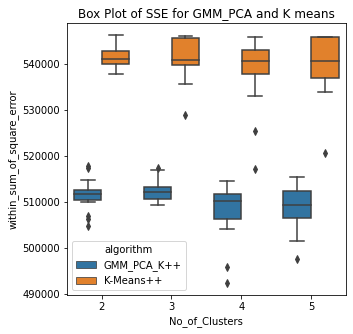

In [426]:
import seaborn as sns
expectation_maximization_statistics_kmeans_plus_plus_pca_df['algorithm']='GMM_PCA_K++'
error_values_kmeans_pca_df['algorithm']='K-Means++'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_kmeans_plus_plus_pca_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_kmeans_plus_plus_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='within_sum_of_square_error', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['K-Means++','GMM_PCA_K++'])],ax=ax);
plt.title('Box Plot of SSE for GMM_PCA and K means')
plt.show()

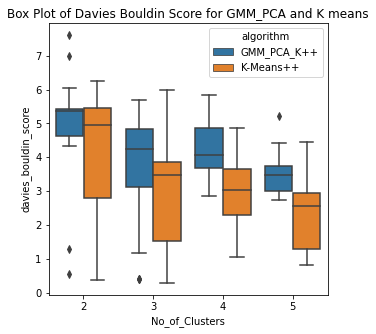

In [427]:
import seaborn as sns
expectation_maximization_statistics_kmeans_plus_plus_pca_df['algorithm']='GMM_PCA_K++'
error_values_kmeans_pca_df['algorithm']='K-Means++'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_kmeans_plus_plus_pca_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_kmeans_plus_plus_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='davies_bouldin_score', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['K-Means++','GMM_PCA_K++'])],ax=ax);
plt.title('Box Plot of Davies Bouldin Score for GMM_PCA and K means')
plt.show()

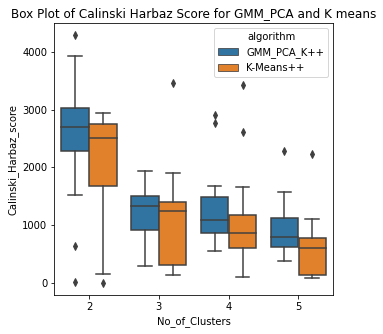

In [431]:
import seaborn as sns
expectation_maximization_statistics_kmeans_plus_plus_pca_df['algorithm']='GMM_PCA_K++'
error_values_kmeans_pca_df['algorithm']='K-Means++'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_kmeans_plus_plus_pca_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_kmeans_plus_plus_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='Calinski_Harbaz_score', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['K-Means++','GMM_PCA_K++'])],ax=ax);
plt.title('Box Plot of Calinski Harbaz Score for GMM_PCA and K means')
plt.show()

# K means with inital clusters and saving them for EMM

In [841]:
import numpy as np
import swifter
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
import time
def get_random_centroids(input_dataframe,no_of_clusters):
    list_of_centroids = []
    for cluster in range(no_of_clusters):
        random_centroid = input_dataframe.swifter.apply(lambda x:float(x.sample()))
        list_of_centroids.append(random_centroid)
    
    centroid_df=pd.concat(list_of_centroids,axis=1)
    centroid_df.index.name='Cluster_Assigned'
    return centroid_df

def get_labels(input_dataframe,centroid_df):
    euclidean_distances = centroid_df.swifter.apply(lambda x: np.sqrt(((input_dataframe - x) ** 2).sum(axis=1)))
    return pd.DataFrame(euclidean_distances.idxmin(axis=1))

        
def get_new_centroids(df_clustered_label,input_dataframe):
    df_original_label_join=input_dataframe.join(df_clustered_label)
    df_original_label_join.rename(columns={0:'Cluster_Assigned'},inplace=True)
    new_centroids=df_original_label_join.groupby('Cluster_Assigned').mean()
    return new_centroids.T


def kmeans_llyod(input_dataframe,no_of_clusters,threshold,no_of_iterations):
    start_time=time.time()
    iteration=0
    initial_centroid=get_random_centroids(input_dataframe,no_of_clusters)
    same_centroid=initial_centroid
    initial_centroid_column_list=initial_centroid.columns.to_list()
    
    while True:
        
        df_cluster_label=get_labels(input_dataframe,initial_centroid)
        df_new_centroids=get_new_centroids(df_cluster_label,input_dataframe)
        new_list_of_columns=df_new_centroids.columns.to_list()
        initial_set_columns = set(initial_centroid_column_list)
        new_set_columns = set(new_list_of_columns)
        missing_columns = initial_set_columns - new_set_columns
        for col in missing_columns:
            df_new_centroids[col]=initial_centroid[col]
        
        from scipy.spatial.distance import euclidean
        scalar_product = [euclidean(initial_centroid[col],df_new_centroids[col]) for col in initial_centroid.columns]
        threshold_calculated=float(sum(scalar_product))/no_of_clusters
        
        iteration+=1
        
        if threshold_calculated<threshold:
            print("The input Threshold was {}".format(threshold))
            print("The calculated threshold is {}".format(threshold_calculated))
        
        if iteration>no_of_iterations:
            print("Limit for iterations has exceeded")
        
        if threshold_calculated<threshold or iteration>no_of_iterations:
            sum_of_square_error=sum_of_square_error_function(df_cluster_label,input_dataframe,df_new_centroids,no_of_clusters)
            df_cluster_label_copy=df_cluster_label.copy()
            df_cluster_label_copy.rename(columns={0:'Cluster_Assigned'},inplace=True)
            labels=df_cluster_label_copy['Cluster_Assigned'].to_list()
            #silheoutte_score=silheoutte_score_Kmeans(input_dataframe,labels)
            silheoutte_score=0
            chs_score=Calinski_Harbaz_score_Kmeans(input_dataframe,labels)
            dbs_score=davies_bouldin_score(input_dataframe,labels)
            end_time=time.time()
            return df_new_centroids,sum_of_square_error,silheoutte_score,chs_score,dbs_score,end_time-start_time,same_centroid
            break
        else:
            initial_centroid= df_new_centroids
        

def sum_of_square_error_function(df_cluster_label,input_dataframe,df_new_centroids,no_of_clusters):
    df_data_label=input_dataframe.join(df_cluster_label)
    df_data_label.rename(columns={0:'Cluster_Assigned'},inplace=True)
    total_error=[]
    for cluster in range(no_of_clusters):
        df_data_label_cluster=df_data_label[df_data_label['Cluster_Assigned']==cluster]
        df_data_label_cluster=df_data_label_cluster.drop('Cluster_Assigned',axis=1)
        centroids=pd.DataFrame(df_new_centroids[cluster])
        euclidean_distance=cdist(df_data_label_cluster,centroids.T,metric='euclidean')
        total_error.append(sum(euclidean_distance))
    return round(float(''.join(map(str, sum(total_error)))),3)

def silheoutte_score_Kmeans(input_dataframe,labels):
    from sklearn.metrics import silhouette_score
    silhouette_avg = silhouette_score(input_dataframe, labels)
    return silhouette_avg

def Calinski_Harbaz_score_Kmeans(input_dataframe,labels):
    from sklearn.metrics import calinski_harabasz_score
    chs=calinski_harabasz_score(input_dataframe,labels)
    return chs


def davies_bouldin_score(input_dataframe,labels):
    from sklearn.metrics import davies_bouldin_score
    dbs=davies_bouldin_score(input_dataframe,labels)
    return dbs

from scipy.stats import multivariate_normal
import numpy as np

def initialization_of_GMM(input_dataframe,no_of_clusters):
    '''
    The function takes scaled dataframe as input and initializes the GMM means,Covariances,and Weights
    '''
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    # Randomly initialize means vector
    means_vector = np.array(get_random_centroids(input_dataframe,no_of_clusters).T)
    # Initialize covariance matrices for each cluster
    covariances_vector = np.array([np.eye(column)] * no_of_clusters)
    # Initialize weights from uniform distribution
    weights_vector = np.ones(no_of_clusters)/no_of_clusters
    return means_vector,covariances_vector,weights_vector
    
    
def fit_Guassian_mixture_models(input_dataframe,no_of_clusters,max_no_of_iterations,threshold):
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    means,covariances,weights=initialization_of_GMM(input_dataframe,no_of_clusters)
    iteration = 0
    previous_log_likelihood_scalar=0
    while iteration < max_no_of_iterations:
       
        new_log_likelihood = 0
        for index in range(no_of_clusters):
            try:
                epsilon_weight=1e-6
                cov_inv = np.linalg.pinv(covariances[index] + np.diag(np.ones(covariances[index].shape[0]) * epsilon_weight))
                new_log_likelihood=new_log_likelihood+weights[index]*multivariate_normal.logpdf(input_dataframe_values,means[index], cov_inv)
            except np.linalg.LinAlgError as e:
                continue
        new_log_likelihood_scalar=np.sum(new_log_likelihood)
        
        '''
        Calculating percentage change
        '''
        if np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))<threshold:
            print("The input Threshold was {}".format(threshold))
            print("The calculated threshold is {}".format(np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))))
            break
        #else:
            #print("The input Threshold was {}".format(threshold))
            #print("The calculated threshold is {}".format(np.abs(((np.abs(new_log_likelihood_scalar-previous_log_likelihood_scalar)/new_log_likelihood_scalar)*100))))
            
        
        previous_log_likelihood_scalar=new_log_likelihood_scalar
        
        posterior_probabilities = np.zeros((len(input_dataframe_values),no_of_clusters))
        for index in range(no_of_clusters):
            try:
                cov_inv = np.linalg.pinv(covariances[index],rcond=1e-10)
            except np.linalg.LinAlgError as e:
                continue
            try:
                posterior_probabilities[:,index] = weights[index] * multivariate_normal.pdf(input_dataframe_values, means[index], cov_inv)
            except np.linalg.LinAlgError as e:
                continue
        posterior_probabilities/=np.sum(posterior_probabilities, axis=1, keepdims=True)

        
        
        for j in range(no_of_clusters):
            weighted_sum = np.zeros((1, means.shape[1]))
            sum_posterior = 0.0
            for i in range(row):
                weighted_sum += posterior_probabilities[i][j] * input_dataframe_values[i]
                sum_posterior += posterior_probabilities[i][j]
            means[j] = weighted_sum/sum_posterior
            difference = input_dataframe_values - means[j]
            covariances[j] = np.dot((difference * posterior_probabilities[:, j][:, np.newaxis]).T, difference) / np.sum(posterior_probabilities[:, j])
            covariances[j] += np.diag(np.ones(column) * 1e-6)
            weights[j] = np.mean(posterior_probabilities[:, j])
        
        
        
        iteration += 1
        
    return means,posterior_probabilities


In [842]:
error_values_kmeans_same_centroid=[]
error_values_emm_same_centroid=[]
for no_of_clusters in range(2,6):
    print(no_of_clusters)
    for no_of_experiments in range(1,21):
        print(no_of_experiments)
        final_centroids,sum_of_squared_error,sil_score,chs_score,dbs_score,run_time,same_centroid=kmeans_llyod(pd.DataFrame(df_diabetes_scaled),no_of_clusters,10,100)
        error_values_kmeans_same_centroid.append([no_of_clusters,no_of_experiments,sum_of_squared_error,sil_score,chs_score,dbs_score,run_time])
        means,posterior_probabilities=fit_Guassian_mixture_models(df_diabetes_scaled,no_of_clusters,100,1)
        cluster_labels_original=np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1))
        cluster_labels_array=np.unique(np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1)))
        list_of_clusters=np.array([i for i in range(0,no_of_clusters)])
        missing_clusters=set(list_of_clusters)-set(cluster_labels_array)
        for missing_value in missing_clusters:
            unique_values,value_counts=np.unique(cluster_labels_original,return_counts=True)
            values_to_replace=unique_values[value_counts > 1]
            value_to_replace=np.random.choice(values_to_replace)
            indices=np.where(cluster_labels_original==value_to_replace)[0]
            random_index=np.random.choice(indices)
            new_value=missing_value
            cluster_labels_original[random_index]=new_value
        cluster_labels_array=cluster_labels_original
        within_sum_of_square_error=wcss_emm(df_diabetes_scaled,cluster_labels_array,no_of_clusters)
        Calinski_Harbaz_score_value=Calinski_Harbaz_score(df_diabetes_scaled,cluster_labels_array)
        dbs_value=davies_bouldin_score(df_diabetes_scaled,cluster_labels_array)
        error_values_emm_same_centroid.append([no_of_clusters,no_of_experiments,within_sum_of_square_error,silheoutte_score_value,Calinski_Harbaz_score_value,dbs_value])
        print("Appended_to_dataframe")
expectation_maximization_statistics_same_centroid_df= pd.DataFrame(error_values_emm_same_centroid,columns=['No_of_Clusters', 'Iteration Number', 'within_sum_of_square_error','silheoutte_score','Calinski_Harbaz_score','davies_bouldin_score'])
error_values_kmeans_same_centroid_df= pd.DataFrame(error_values_kmeans_same_centroid,columns=['No_of_Clusters', 'Iteration Number','within_sum_of_square_error','Silheoutte_Score','Calinski_Harbaz_score','davies_bouldin_score','run_time'])  

2
1


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.304385785051611


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.5760332135162691
Appended_to_dataframe
2


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.5091122190039314


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.15551449557691904
Appended_to_dataframe
3


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.336876137274314


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Appended_to_dataframe
4


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.0773468958625276


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Appended_to_dataframe
5


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.902257815294885


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.32670338330734827
Appended_to_dataframe
6


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.441232904378225


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.1934388115545898
Appended_to_dataframe
7


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.295665496521359


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.9531271059513112
Appended_to_dataframe
8


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.982336178746026


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.8739789428722934
Appended_to_dataframe
9


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.469893743511598


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Appended_to_dataframe
10


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.6613758130650282


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Appended_to_dataframe
11


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.55144027832235


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 3.483056739770093e-08
Appended_to_dataframe
12


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.582164565054887


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.01302696331533143
Appended_to_dataframe
13


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.234032673217071


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.8540033296407404
Appended_to_dataframe
14


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.3291696064578327


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.7174815126498914
Appended_to_dataframe
15


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.4103959985393146


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.5750583946221618
Appended_to_dataframe
16


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.358367795171008


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Appended_to_dataframe
17


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.031342399228307


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.514013859922581
Appended_to_dataframe
18


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.886932095210093


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.4947998814660037
Appended_to_dataframe
19


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.779202053671941


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.3792123963718881
Appended_to_dataframe
20


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.6394356313102048


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Appended_to_dataframe
3
1


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.309983042568347


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

/tmp/ipykernel_19373/3392056510.py:175: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.1343763141426416
Appended_to_dataframe
2


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.963203859801492


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.2355871966695325
Appended_to_dataframe
3


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.193592207048154


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Appended_to_dataframe
4


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.5001740780503545


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Appended_to_dataframe
5


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.252272556674897


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.09183893213707553
Appended_to_dataframe
6


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.164367225943784


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

/tmp/ipykernel_19373/3392056510.py:175: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.7769607406423524
Appended_to_dataframe
7


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.2955537067617726


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.5105363447608139
Appended_to_dataframe
8


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.565787217151107


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.8678354687396408
Appended_to_dataframe
9


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.1281641524155175


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.9864348655994868
Appended_to_dataframe
10


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.369510622462624


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.7909954334304683
Appended_to_dataframe
11


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.9421260521915515


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.265941318229311
Appended_to_dataframe
12


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.977096955223646


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.21388966205749155
Appended_to_dataframe
13


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.266770353341155


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.4541224649026875
Appended_to_dataframe
14


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.240043905256317


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.29677963380312294
Appended_to_dataframe
15


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 5.585316400942889


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

/tmp/ipykernel_19373/3392056510.py:175: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.2025419617011979
Appended_to_dataframe
16


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.5903594792984075


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.27571776178298235
Appended_to_dataframe
17


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.972089842030069


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.570357956873875
Appended_to_dataframe
18


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8407891342434084


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.42714056276017154
Appended_to_dataframe
19


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.1642547933762915


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.9504851540802675
Appended_to_dataframe
20


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.339324541035643


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.5560196429059747
Appended_to_dataframe
4
1


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.341787406368533


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.05686150786727589
Appended_to_dataframe
2


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.676186198662114


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.4788349311418522
Appended_to_dataframe
3


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.5916424131170386


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.08949929626641863
Appended_to_dataframe
4


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.330153948672619


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.5722109089994029
Appended_to_dataframe
5


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.269801988685004


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.05525531835902986
Appended_to_dataframe
6


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.641642983549042


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.27295588153168715
Appended_to_dataframe
7


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.8159483165964185


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.5883451236375071
Appended_to_dataframe
8


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9626740593225738


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.3830127050051014
Appended_to_dataframe
9


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.877183474276651


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

/tmp/ipykernel_19373/3392056510.py:175: RuntimeWarning: invalid value encountered in divide
  means[j] = weighted_sum/sum_posterior


The input Threshold was 1
The calculated threshold is 0.013956548599801635
Appended_to_dataframe
10


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.7879648237575676


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.03950706864829597
Appended_to_dataframe
11


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9217857753544


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.8079066357439308
Appended_to_dataframe
12


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.939500002633676


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.6999620773351716
Appended_to_dataframe
13


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.629621296507249


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.6982167507812959
Appended_to_dataframe
14


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.219615099701059


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.6040640044854352
Appended_to_dataframe
15


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9564702868126975


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.6260136705778894
Appended_to_dataframe
16


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.869141723727608


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.33448080402710545
Appended_to_dataframe
17


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.476638050936983


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.40059477149939515
Appended_to_dataframe
18


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.483200281836015


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.4058957929065584
Appended_to_dataframe
19


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.803692954261798


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.3100209421985325
Appended_to_dataframe
20


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.79236925381208


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.05205374460403743
Appended_to_dataframe
5
1


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.481284736997941


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.2947559731095487
Appended_to_dataframe
2


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.905363856549428


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.3988603339166114
Appended_to_dataframe
3


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9291391304459573


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.04837456550448391
Appended_to_dataframe
4


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.20730831605645


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.39596279209211843
Appended_to_dataframe
5


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.136285885544598


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.5901978940687063
Appended_to_dataframe
6


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.4022282220274476


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.9028527276143253
Appended_to_dataframe
7


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.5580284082726052


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.5790327048179762
Appended_to_dataframe
8


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.500910998852114


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.516704620752274
Appended_to_dataframe
9


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.460536964258655


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.8244075476534533
Appended_to_dataframe
10


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.897088473687132


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.795380073805877
Appended_to_dataframe
11


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.200865928351794


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.7788679306067203
Appended_to_dataframe
12


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.7692895999398828


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.1424626033528619
Appended_to_dataframe
13


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.562722662091943


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.017880425070076304
Appended_to_dataframe
14


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.839305992570377


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.6387522427550948
Appended_to_dataframe
15


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.9296895795160003


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.21682790537625052
Appended_to_dataframe
16


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.693521288672764


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.22917585421122216
Appended_to_dataframe
17


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 4.1077007920482105


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.2698558836696217
Appended_to_dataframe
18


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.21359754321465


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.5365784803241602
Appended_to_dataframe
19


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.456356165410713


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.39559193428063183
Appended_to_dataframe
20


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

The input Threshold was 10
The calculated threshold is 3.6146167193816994


Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

The input Threshold was 1
The calculated threshold is 0.5246871932798874
Appended_to_dataframe


In [843]:
expectation_maximization_statistics_same_centroid_df

,No_of_Clusters,Iteration Number,within_sum_of_square_error,silheoutte_score,Calinski_Harbaz_score,davies_bouldin_score
0,2,1,531529.839,0.034248,2065.405888,5.897988
1,2,2,529865.032,0.034248,2636.436467,5.855585
2,2,3,536071.495,0.034248,404.938333,1.328084
3,2,4,536356.159,0.034248,0.578944,1.249206
4,2,5,527970.274,0.034248,2609.121870,5.439656
...,...,...,...,...,...,...
75,5,16,535680.245,0.034248,177.380814,1.049605
76,5,17,515211.097,0.034248,1847.949140,4.411451
77,5,18,535863.253,0.034248,128.119275,1.588993
78,5,19,531428.733,0.034248,698.172925,1.587770


In [844]:
error_values_kmeans_same_centroid_df

,No_of_Clusters,Iteration Number,within_sum_of_square_error,Silheoutte_Score,Calinski_Harbaz_score,davies_bouldin_score,run_time
0,2,1,529760.976,0,2269.196908,6.239323,1.095549
1,2,2,531618.621,0,2102.627784,2.327312,0.969431
2,2,3,531264.220,0,1777.829162,5.234356,0.919540
3,2,4,528152.522,0,2722.658281,3.978735,0.945715
4,2,5,531371.806,0,1989.807430,4.971577,0.882002
...,...,...,...,...,...,...,...
75,5,16,512800.741,0,2408.299964,3.633220,1.842269
76,5,17,514175.144,0,2497.596192,3.243130,1.878481
77,5,18,509275.371,0,2394.837341,4.214970,1.979473
78,5,19,516721.052,0,1726.248517,4.143291,1.670300


# Saving all the Dataframes

In [845]:
expectation_maximization_statistics_df.to_csv('expectation_maximization_statistics_df.csv')
expectation_maximization_statistics_kmeans_plus_plus_df.to_csv('expectation_maximization_statistics_kmeans_plus_plus_df.csv')
expectation_maximization_statistics_kmeans_plus_plus_pca_df.to_csv('expectation_maximization_statistics_kmeans_plus_plus_pca_df.csv')
expectation_maximization_statistics_same_centroid_df.to_csv('expectation_maximization_statistics_same_centroid_df.csv')
error_values_kmeans_same_centroid_df.to_csv('error_values_kmeans_same_centroid_df.csv')

# Reading the Dataframes

In [393]:
expectation_maximization_statistics_df=pd.read_csv('expectation_maximization_statistics_df.csv')
expectation_maximization_statistics_kmeans_plus_plus_df=pd.read_csv('expectation_maximization_statistics_kmeans_plus_plus_df.csv')
expectation_maximization_statistics_kmeans_plus_plus_pca_df=pd.read_csv('expectation_maximization_statistics_kmeans_plus_plus_pca_df.csv')
expectation_maximization_statistics_same_centroid_df=pd.read_csv('expectation_maximization_statistics_same_centroid_df.csv')
error_values_kmeans_same_centroid_df=pd.read_csv('error_values_kmeans_same_centroid_df.csv')

In [394]:
expectation_maximization_statistics_df.head(1)

,Unnamed: 0,No_of_Clusters,Iteration Number,within_sum_of_square_error,silheoutte_score,Calinski_Harbaz_score,davies_bouldin_score
0,0,2,1,545710.775,0.034248,500.090441,0.667274


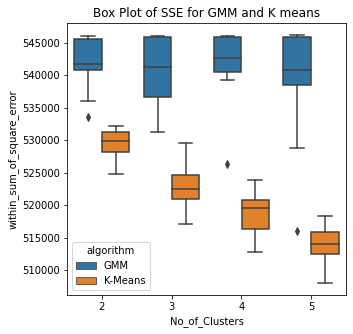

In [405]:
import seaborn as sns
expectation_maximization_statistics_df['algorithm']='GMM'
error_values_kmeans_same_centroid_df['algorithm']='K-Means'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_same_centroid_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='within_sum_of_square_error', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['K-Means','GMM'])],ax=ax);
plt.title('Box Plot of SSE for GMM and K means')
plt.show()

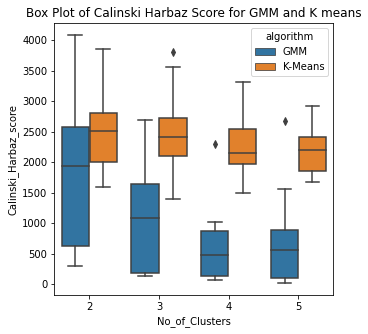

In [408]:
import seaborn as sns
expectation_maximization_statistics_df['algorithm']='GMM'
error_values_kmeans_same_centroid_df['algorithm']='K-Means'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_same_centroid_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='Calinski_Harbaz_score', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['K-Means','GMM'])],ax=ax);
plt.title('Box Plot of Calinski Harbaz Score for GMM and K means')
plt.show()

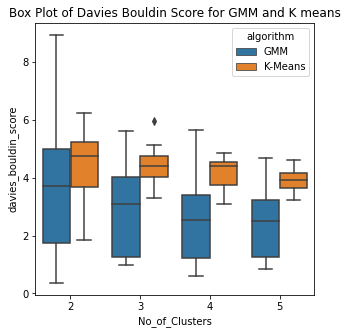

In [409]:
import seaborn as sns
expectation_maximization_statistics_df['algorithm']='GMM'
error_values_kmeans_same_centroid_df['algorithm']='K-Means'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_same_centroid_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='davies_bouldin_score', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['K-Means','GMM'])],ax=ax);
plt.title('Box Plot of Davies Bouldin Score for GMM and K means')
plt.show()

# Other Types of Distributions-Poisson Distribution k++

In [22]:
df_sample_scaled.columns=df_diabetes.columns

In [252]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_sample_scaled = pd.DataFrame(scaler.fit_transform(df_sample_scaled), columns=df.columns)
df_sample_scaled

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,change,diabetesMed,readmitted,gender_Female,gender_Male,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other
0,0.000000,1.0,1.000000,0.000000,0.000000,0.483871,0.000000,0.000000,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.111111,0.0,0.000000,1.000000,0.166667,0.774194,0.000000,0.629630,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.222222,0.0,0.000000,1.000000,0.083333,0.000000,0.833333,0.444444,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.333333,0.0,0.000000,1.000000,0.083333,0.532258,0.166667,0.555556,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.444444,0.0,0.000000,1.000000,0.000000,0.645161,0.000000,0.259259,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0.555556,0.2,0.000000,0.166667,0.166667,0.322581,1.000000,0.555556,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,0.666667,0.4,0.000000,0.166667,0.250000,0.951613,0.166667,0.740741,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,0.777778,0.0,0.000000,1.000000,0.333333,1.000000,0.000000,0.407407,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,0.888889,0.2,0.000000,0.500000,1.000000,0.919355,0.333333,1.000000,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,1.000000,0.4,0.083333,0.500000,0.916667,0.354839,0.500000,0.629630,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [374]:
from scipy.stats import multivariate_normal
from scipy.special import gamma
import numpy as np
import math 

def initialization_of_Poisson(input_dataframe,no_of_clusters):
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    means_vector = input_dataframe_values[np.random.choice(input_dataframe_values.shape[0], no_of_clusters,replace=False), :]
    weights_vector = np.ones(no_of_clusters)/no_of_clusters
    return means_vector,weights_vector

def get_poisson(input_dataframe_values,means,weights,no_of_clusters):
    posterior_clusters=np.zeros(no_of_clusters)
    gamma_array=np.array([math.gamma(index+1) for index in input_dataframe_values])
    for cluster in range(no_of_clusters):
        temp=np.exp(-means[cluster])*np.power(means[cluster],input_dataframe_values)/gamma_array
        posterior_clusters[cluster]=weights[cluster]*np.prod(temp)+0.0001
    return posterior_clusters
    

    
def fit_Poisson_mixture_models(input_dataframe,no_of_clusters,max_no_of_iterations,threshold):
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    means,weights=initialization_of_Poisson(input_dataframe,no_of_clusters)
    iteration = 0
    previous_log_likelihood_scalar=0
    while iteration < max_no_of_iterations:
        previous_means_df=pd.DataFrame(means)
        posterior_probabilities = np.zeros((len(input_dataframe_values),no_of_clusters))
        for row_number in range(input_dataframe_values.shape[0]):
            posterior_probabilities[row_number]=get_poisson(input_dataframe_values[row_number],means,weights,no_of_clusters)
        posterior_probabilities=np.nan_to_num(posterior_probabilities,nan=0)
        
        for j in range(no_of_clusters):
            weighted_sum = np.zeros((1, means.shape[1]))
            sum_posterior = 0.0
            for i in range(row):
                weighted_sum += posterior_probabilities[i][j] * input_dataframe_values[i]
                sum_posterior += posterior_probabilities[i][j]
            means[j] = weighted_sum/sum_posterior
            weights[j] = np.mean(posterior_probabilities[:, j])
        new_means_df=pd.DataFrame(means)
        euclidean_distance=[]
        for col in new_means_df.columns:
            col_distance = euclidean(previous_means_df[col], new_means_df[col])
            euclidean_distance.append(col_distance)
        threshold_calculated=sum(euclidean_distance)/no_of_clusters
        iteration += 1
        if threshold_calculated<threshold:
            return means,posterior_probabilities
        if iteration>max_no_of_iterations:
            return means,posterior_probabilities
        iteration += 1
        
    return means,posterior_probabilities

In [375]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(df_diabetes_scaled)
df_diabetes_scaled_min_max=scaler.transform(df_diabetes_scaled)
df_diabetes_scaled_min_max=pd.DataFrame(df_diabetes_scaled_min_max)
expectation_maximization_statistics_poisson=[]
for no_of_clusters in range(2,6):
    print(no_of_clusters)
    for no_of_experiments in range(1,21):
        print(no_of_experiments)
        means,posterior_probabilities=fit_Poisson_mixture_models(df_diabetes_scaled_min_max,no_of_clusters,100,10)
        cluster_labels_original=np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1))
        cluster_labels_array=np.unique(np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1)))
        list_of_clusters=np.array([i for i in range(0,no_of_clusters)])
        missing_clusters=set(list_of_clusters)-set(cluster_labels_array)
        for missing_value in missing_clusters:
            unique_values,value_counts=np.unique(cluster_labels_original,return_counts=True)
            values_to_replace=unique_values[value_counts > 1]
            value_to_replace=np.random.choice(values_to_replace)
            indices=np.where(cluster_labels_original==value_to_replace)[0]
            if len(indices)==0:
                indices=[0]
            random_index=np.random.choice(indices)
            new_value=missing_value
            cluster_labels_original[random_index]=new_value
        cluster_labels_array=cluster_labels_original
        within_sum_of_square_error=wcss_emm(df_diabetes_scaled_min_max,cluster_labels_array,no_of_clusters)
        Calinski_Harbaz_score_value=Calinski_Harbaz_score(df_diabetes_scaled_min_max,cluster_labels_array)
        dbs_value=davies_bouldin_score(df_diabetes_scaled_min_max,cluster_labels_array)
        silheoutte_score_value=0
        expectation_maximization_statistics_poisson.append([no_of_clusters,no_of_experiments,within_sum_of_square_error,silheoutte_score_value,Calinski_Harbaz_score_value,dbs_value])
        print("Appended_to_dataframe")
expectation_maximization_statistics_poisson_df= pd.DataFrame(expectation_maximization_statistics_poisson,columns=['No_of_Clusters', 'Iteration Number', 'within_sum_of_square_error','silheoutte_score','Calinski_Harbaz_score','davies_bouldin_score'])

2
1
Appended_to_dataframe
2
Appended_to_dataframe
3
Appended_to_dataframe
4
Appended_to_dataframe
5
Appended_to_dataframe
6
Appended_to_dataframe
7
Appended_to_dataframe
8
Appended_to_dataframe
9
Appended_to_dataframe
10
Appended_to_dataframe
11
Appended_to_dataframe
12
Appended_to_dataframe
13
Appended_to_dataframe
14
Appended_to_dataframe
15
Appended_to_dataframe
16
Appended_to_dataframe
17
Appended_to_dataframe
18
Appended_to_dataframe
19
Appended_to_dataframe
20
Appended_to_dataframe
3
1
Appended_to_dataframe
2
Appended_to_dataframe
3
Appended_to_dataframe
4
Appended_to_dataframe
5
Appended_to_dataframe
6
Appended_to_dataframe
7
Appended_to_dataframe
8
Appended_to_dataframe
9
Appended_to_dataframe
10
Appended_to_dataframe
11
Appended_to_dataframe
12
Appended_to_dataframe
13
Appended_to_dataframe
14
Appended_to_dataframe
15
Appended_to_dataframe
16
Appended_to_dataframe
17
Appended_to_dataframe
18
Appended_to_dataframe
19
Appended_to_dataframe
20
Appended_to_dataframe
4
1
Appended_t

In [377]:
expectation_maximization_statistics_poisson_df.to_csv('expectation_maximization_statistics_poisson_df.csv')

# Running code for Exponential Distribution

In [383]:
from scipy.stats import multivariate_normal
from scipy.special import gamma
import numpy as np
import math 

def initialization_of_exponential(input_dataframe,no_of_clusters):
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    means_vector = input_dataframe_values[np.random.choice(input_dataframe_values.shape[0], no_of_clusters,replace=False), :]
    weights_vector = np.ones(no_of_clusters)/no_of_clusters
    return means_vector,weights_vector

def get_exponential(input_dataframe_values,means,weights,no_of_clusters):
    posterior_clusters=np.zeros(no_of_clusters)
    for cluster in range(no_of_clusters):
        mean_temp=1/(means[cluster]+0.01)
        exponential=np.exp(-mean_temp*input_dataframe_values)/mean_temp
        posterior_clusters[cluster] = weights[cluster]*np.prod(exponential)+0.0001
    return posterior_clusters
    

    
def fit_exponential_mixture_models(input_dataframe,no_of_clusters,max_no_of_iterations,threshold):
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    means,weights=initialization_of_exponential(input_dataframe,no_of_clusters)
    iteration = 0
    previous_log_likelihood_scalar=0
    while iteration < max_no_of_iterations:
        previous_means_df=pd.DataFrame(means)
        posterior_probabilities = np.zeros((len(input_dataframe_values),no_of_clusters))
        for row_number in range(input_dataframe_values.shape[0]):
            posterior_probabilities[row_number]=get_exponential(input_dataframe_values[row_number],means,weights,no_of_clusters)
        posterior_probabilities=np.nan_to_num(posterior_probabilities,nan=0)
        
        for j in range(no_of_clusters):
            weighted_sum = np.zeros((1, means.shape[1]))
            sum_posterior = 0.0
            for i in range(row):
                weighted_sum += posterior_probabilities[i][j] * input_dataframe_values[i]
                sum_posterior += posterior_probabilities[i][j]
            means[j] = weighted_sum/sum_posterior
            weights[j] = np.mean(posterior_probabilities[:, j])
        new_means_df=pd.DataFrame(means)
        euclidean_distance=[]
        for col in new_means_df.columns:
            col_distance = euclidean(previous_means_df[col], new_means_df[col])
            euclidean_distance.append(col_distance)
        threshold_calculated=sum(euclidean_distance)/no_of_clusters
        iteration += 1
        if threshold_calculated<threshold:
            return means,posterior_probabilities
        if iteration>max_no_of_iterations:
            return means,posterior_probabilities
        iteration += 1
        
    return means,posterior_probabilities

In [384]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(df_diabetes_scaled)
df_diabetes_scaled_min_max=scaler.transform(df_diabetes_scaled)
df_diabetes_scaled_min_max=pd.DataFrame(df_diabetes_scaled_min_max)
expectation_maximization_statistics_exponential=[]
for no_of_clusters in range(2,6):
    print(no_of_clusters)
    for no_of_experiments in range(1,21):
        print(no_of_experiments)
        means,posterior_probabilities=fit_exponential_mixture_models(df_diabetes_scaled_min_max,no_of_clusters,100,10)
        cluster_labels_original=np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1))
        cluster_labels_array=np.unique(np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1)))
        list_of_clusters=np.array([i for i in range(0,no_of_clusters)])
        missing_clusters=set(list_of_clusters)-set(cluster_labels_array)
        for missing_value in missing_clusters:
            unique_values,value_counts=np.unique(cluster_labels_original,return_counts=True)
            values_to_replace=unique_values[value_counts > 1]
            value_to_replace=np.random.choice(values_to_replace)
            indices=np.where(cluster_labels_original==value_to_replace)[0]
            if len(indices)==0:
                indices=[0]
            random_index=np.random.choice(indices)
            new_value=missing_value
            cluster_labels_original[random_index]=new_value
        cluster_labels_array=cluster_labels_original
        within_sum_of_square_error=wcss_emm(df_diabetes_scaled_min_max,cluster_labels_array,no_of_clusters)
        Calinski_Harbaz_score_value=Calinski_Harbaz_score(df_diabetes_scaled_min_max,cluster_labels_array)
        dbs_value=davies_bouldin_score(df_diabetes_scaled_min_max,cluster_labels_array)
        silheoutte_score_value=0
        expectation_maximization_statistics_exponential.append([no_of_clusters,no_of_experiments,within_sum_of_square_error,silheoutte_score_value,Calinski_Harbaz_score_value,dbs_value])
        print("Appended_to_dataframe")
expectation_maximization_statistics_exponential_df= pd.DataFrame(expectation_maximization_statistics_exponential,columns=['No_of_Clusters', 'Iteration Number', 'within_sum_of_square_error','silheoutte_score','Calinski_Harbaz_score','davies_bouldin_score'])

2
1
Appended_to_dataframe
2
Appended_to_dataframe
3
Appended_to_dataframe
4
Appended_to_dataframe
5
Appended_to_dataframe
6
Appended_to_dataframe
7
Appended_to_dataframe
8
Appended_to_dataframe
9
Appended_to_dataframe
10
Appended_to_dataframe
11
Appended_to_dataframe
12
Appended_to_dataframe
13
Appended_to_dataframe
14
Appended_to_dataframe
15
Appended_to_dataframe
16
Appended_to_dataframe
17
Appended_to_dataframe
18
Appended_to_dataframe
19
Appended_to_dataframe
20
Appended_to_dataframe
3
1
Appended_to_dataframe
2
Appended_to_dataframe
3
Appended_to_dataframe
4
Appended_to_dataframe
5
Appended_to_dataframe
6
Appended_to_dataframe
7
Appended_to_dataframe
8
Appended_to_dataframe
9
Appended_to_dataframe
10
Appended_to_dataframe
11
Appended_to_dataframe
12
Appended_to_dataframe
13
Appended_to_dataframe
14
Appended_to_dataframe
15
Appended_to_dataframe
16
Appended_to_dataframe
17
Appended_to_dataframe
18
Appended_to_dataframe
19
Appended_to_dataframe
20
Appended_to_dataframe
4
1
Appended_t

In [386]:
expectation_maximization_statistics_exponential_df.to_csv('expectation_maximization_statistics_exponential_df.csv')

# Running GMM on min max scaled dataset

In [388]:
from scipy.stats import multivariate_normal
import numpy as np
from scipy.spatial.distance import euclidean

def initialization_of_GMM(input_dataframe,no_of_clusters):
    '''
    The function takes scaled dataframe as input and initializes the GMM means,Covariances,and Weights
    '''
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    # Randomly initialize means vector
    means_vector = input_dataframe_values[np.random.choice(input_dataframe_values.shape[0], no_of_clusters, replace=False), :]
    # Initialize covariance matrices for each cluster
    covariances_vector = np.array([np.eye(column)] * no_of_clusters)
    # Initialize weights from uniform distribution
    weights_vector = np.ones(no_of_clusters) / no_of_clusters
    return means_vector,covariances_vector,weights_vector
    
    
def fit_Guassian_mixture_models_scaled(input_dataframe,no_of_clusters,max_no_of_iterations,threshold):
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    means,covariances,weights=initialization_of_GMM(input_dataframe,no_of_clusters)
    iteration = 0
    previous_log_likelihood_scalar=0
    while iteration < max_no_of_iterations:
       
        new_log_likelihood = 0
        for index in range(no_of_clusters):
            try:
                epsilon_weight=1e-6
                cov_inv = np.linalg.pinv(covariances[index] + np.diag(np.ones(covariances[index].shape[0]) * epsilon_weight))
                new_log_likelihood=new_log_likelihood+weights[index]*multivariate_normal.logpdf(input_dataframe_values,means[index], cov_inv)
            except np.linalg.LinAlgError as e:
                continue
        new_log_likelihood_scalar=np.sum(new_log_likelihood)
        previous_means_df=pd.DataFrame(means)
        
        posterior_probabilities = np.zeros((len(input_dataframe_values),no_of_clusters))
        for index in range(no_of_clusters):
            try:
                cov_inv = np.linalg.pinv(covariances[index],rcond=1e-10)
            except np.linalg.LinAlgError as e:
                continue
            try:
                posterior_probabilities[:,index] = weights[index] * multivariate_normal.pdf(input_dataframe_values, means[index], cov_inv)
            except np.linalg.LinAlgError as e:
                continue
        

        
        
        for j in range(no_of_clusters):
            weighted_sum = np.zeros((1, means.shape[1]))
            sum_posterior = 0.0
            for i in range(row):
                weighted_sum += posterior_probabilities[i][j] * input_dataframe_values[i]
                sum_posterior += posterior_probabilities[i][j]
            means[j] = weighted_sum/sum_posterior
            difference = input_dataframe_values - means[j]
            covariances[j] = np.dot((difference * posterior_probabilities[:, j][:, np.newaxis]).T, difference) / np.sum(posterior_probabilities[:, j])
            covariances[j] += np.diag(np.ones(column) * 1e-6)
            weights[j] = np.mean(posterior_probabilities[:, j])
        
        new_means_df=pd.DataFrame(means)
        
        
        euclidean_distance=[]
        for col in new_means_df.columns:
            col_distance = euclidean(previous_means_df[col], new_means_df[col])
            euclidean_distance.append(col_distance)
        threshold_calculated=sum(euclidean_distance)/no_of_clusters
        
        
        iteration += 1
        if threshold_calculated<threshold:
            return means,posterior_probabilities
        if iteration>max_no_of_iterations:
            return means,posterior_probabilities

In [389]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(df_diabetes_scaled)
df_diabetes_scaled_min_max=scaler.transform(df_diabetes_scaled)
df_diabetes_scaled_min_max=pd.DataFrame(df_diabetes_scaled_min_max)
expectation_maximization_statistics_gaussian_min_max=[]
for no_of_clusters in range(2,6):
    print(no_of_clusters)
    for no_of_experiments in range(1,21):
        print(no_of_experiments)
        means,posterior_probabilities=fit_Guassian_mixture_models_scaled(df_diabetes_scaled_min_max,no_of_clusters,100,10)
        cluster_labels_original=np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1))
        cluster_labels_array=np.unique(np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1)))
        list_of_clusters=np.array([i for i in range(0,no_of_clusters)])
        missing_clusters=set(list_of_clusters)-set(cluster_labels_array)
        for missing_value in missing_clusters:
            unique_values,value_counts=np.unique(cluster_labels_original,return_counts=True)
            values_to_replace=unique_values[value_counts > 1]
            value_to_replace=np.random.choice(values_to_replace)
            indices=np.where(cluster_labels_original==value_to_replace)[0]
            if len(indices)==0:
                indices=[0]
            random_index=np.random.choice(indices)
            new_value=missing_value
            cluster_labels_original[random_index]=new_value
        cluster_labels_array=cluster_labels_original
        within_sum_of_square_error=wcss_emm(df_diabetes_scaled_min_max,cluster_labels_array,no_of_clusters)
        Calinski_Harbaz_score_value=Calinski_Harbaz_score(df_diabetes_scaled_min_max,cluster_labels_array)
        dbs_value=davies_bouldin_score(df_diabetes_scaled_min_max,cluster_labels_array)
        silheoutte_score_value=0
        expectation_maximization_statistics_gaussian_min_max.append([no_of_clusters,no_of_experiments,within_sum_of_square_error,silheoutte_score_value,Calinski_Harbaz_score_value,dbs_value])
        print("Appended_to_dataframe")
expectation_maximization_statistics_gaussian_min_max_df= pd.DataFrame(expectation_maximization_statistics_gaussian_min_max,columns=['No_of_Clusters', 'Iteration Number', 'within_sum_of_square_error','silheoutte_score','Calinski_Harbaz_score','davies_bouldin_score'])

2
1
Appended_to_dataframe
2
Appended_to_dataframe
3
Appended_to_dataframe
4
Appended_to_dataframe
5
Appended_to_dataframe
6
Appended_to_dataframe
7
Appended_to_dataframe
8
Appended_to_dataframe
9
Appended_to_dataframe
10
Appended_to_dataframe
11
Appended_to_dataframe
12
Appended_to_dataframe
13
Appended_to_dataframe
14
Appended_to_dataframe
15
Appended_to_dataframe
16
Appended_to_dataframe
17
Appended_to_dataframe
18
Appended_to_dataframe
19
Appended_to_dataframe
20
Appended_to_dataframe
3
1
Appended_to_dataframe
2
Appended_to_dataframe
3
Appended_to_dataframe
4
Appended_to_dataframe
5
Appended_to_dataframe
6
Appended_to_dataframe
7
Appended_to_dataframe
8
Appended_to_dataframe
9
Appended_to_dataframe
10
Appended_to_dataframe
11
Appended_to_dataframe
12
Appended_to_dataframe
13
Appended_to_dataframe
14
Appended_to_dataframe
15
Appended_to_dataframe
16
Appended_to_dataframe
17
Appended_to_dataframe
18
Appended_to_dataframe
19
Appended_to_dataframe
20
Appended_to_dataframe
4
1
Appended_t

In [390]:
expectation_maximization_statistics_gaussian_min_max_df.to_csv('expectation_maximization_statistics_gaussian_min_max_df.csv')

In [391]:
expectation_maximization_statistics_gaussian_min_max_df

,No_of_Clusters,Iteration Number,within_sum_of_square_error,silheoutte_score,Calinski_Harbaz_score,davies_bouldin_score
0,2,1,139977.201,0,6904.231823,3.582470
1,2,2,135524.770,0,13991.679144,2.506603
2,2,3,128971.986,0,23576.987831,1.969810
3,2,4,127720.790,0,26794.659499,1.910164
4,2,5,125438.249,0,32238.341715,1.740171
...,...,...,...,...,...,...
75,5,16,113825.081,0,14672.779191,2.119375
76,5,17,119463.994,0,11141.589081,2.576733
77,5,18,109285.560,0,17529.173895,1.952626
78,5,19,109375.135,0,17698.055640,2.027229


# Plotting the graphs

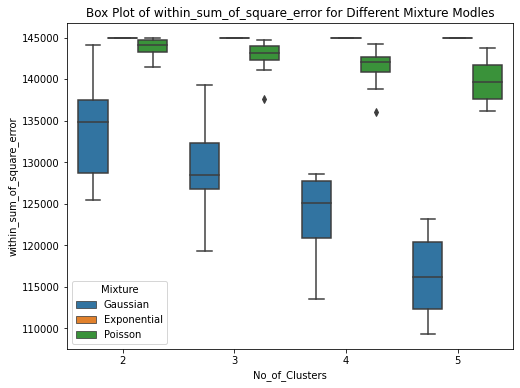

In [436]:
import seaborn as sns
expectation_maximization_statistics_gaussian_min_max_df['Mixture']='Gaussian'
expectation_maximization_statistics_exponential_df['Mixture']='Exponential'
expectation_maximization_statistics_poisson_df['Mixture']='Poisson'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_gaussian_min_max_df[['Mixture','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_exponential_df[['Mixture','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_poisson_df[['Mixture','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]                         
],ignore_index=True )
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='No_of_Clusters', y='within_sum_of_square_error', hue='Mixture',
data=comparison_df[comparison_df['Mixture'].isin (['Gaussian','Exponential','Poisson'])],ax=ax);
plt.title('Box Plot of within_sum_of_square_error for Different Mixture Modles')
plt.show()

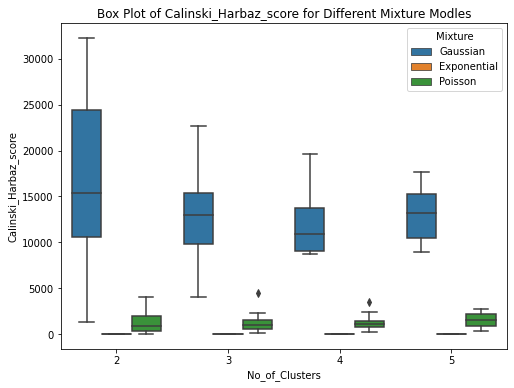

In [439]:
import seaborn as sns
expectation_maximization_statistics_gaussian_min_max_df['Mixture']='Gaussian'
expectation_maximization_statistics_exponential_df['Mixture']='Exponential'
expectation_maximization_statistics_poisson_df['Mixture']='Poisson'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_gaussian_min_max_df[['Mixture','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_exponential_df[['Mixture','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_poisson_df[['Mixture','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]                         
],ignore_index=True )
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='No_of_Clusters', y='Calinski_Harbaz_score', hue='Mixture',
data=comparison_df[comparison_df['Mixture'].isin (['Gaussian','Exponential','Poisson'])],ax=ax);
plt.title('Box Plot of Calinski_Harbaz_score for Different Mixture Modles')
plt.show()

In [ ]:
import seaborn as sns
expectation_maximization_statistics_gaussian_min_max_df['Mixture']='Gaussian'
expectation_maximization_statistics_exponential_df['Mixture']='Exponential'
expectation_maximization_statistics_poisson_df['Mixture']='Poisson'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_gaussian_min_max_df[['Mixture','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_exponential_df[['Mixture','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
expectation_maximization_statistics_poisson_df[['Mixture','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]                         
],ignore_index=True )
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='No_of_Clusters', y='davies_bouldin_score', hue='Mixture',
data=comparison_df[comparison_df['Mixture'].isin (['Gaussian','Exponential','Poisson'])],ax=ax);
plt.title('Box Plot of Davies Bouldin Score for Different Mixture Modles')
plt.show()

# Running EM algorithm without updating covariances and means

In [159]:
from scipy.stats import multivariate_normal
import numpy as np
from scipy.spatial.distance import euclidean

def initialization_of_GMM(input_dataframe,no_of_clusters):
    '''
    The function takes scaled dataframe as input and initializes the GMM means,Covariances,and Weights
    '''
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    # Randomly initialize means vector
    means_vector = input_dataframe_values[np.random.choice(input_dataframe_values.shape[0], no_of_clusters, replace=False), :]
    # Initialize covariance matrices for each cluster
    covariances_vector = np.array([np.eye(column)] * no_of_clusters)
    # Initialize weights from uniform distribution
    weights_vector = np.ones(no_of_clusters) / no_of_clusters
    return means_vector,covariances_vector,weights_vector
    
    
def fit_Guassian_mixture_models_without_covariances(input_dataframe,no_of_clusters,max_no_of_iterations,threshold):
    input_dataframe_values = input_dataframe.values
    row, column = input_dataframe_values.shape
    means,covariances,weights=initialization_of_GMM(input_dataframe,no_of_clusters)
    iteration = 0
    previous_log_likelihood_scalar=0
    while iteration < max_no_of_iterations:
       
        new_log_likelihood = 0
        for index in range(no_of_clusters):
            try:
                epsilon_weight=1e-6
                cov_inv = np.linalg.pinv(covariances[index] + np.diag(np.ones(covariances[index].shape[0]) * epsilon_weight))
                new_log_likelihood=new_log_likelihood+weights[index]*multivariate_normal.logpdf(input_dataframe_values,means[index], cov_inv)
            except np.linalg.LinAlgError as e:
                continue
        new_log_likelihood_scalar=np.sum(new_log_likelihood)
        previous_means_df=pd.DataFrame(means)
        
        posterior_probabilities = np.zeros((len(input_dataframe_values),no_of_clusters))
        for index in range(no_of_clusters):
            try:
                cov_inv = np.linalg.pinv(covariances[index],rcond=1e-10)
            except np.linalg.LinAlgError as e:
                continue
            try:
                posterior_probabilities[:,index] = weights[index] * multivariate_normal.pdf(input_dataframe_values, means[index], cov_inv)
            except np.linalg.LinAlgError as e:
                continue
        

        
        
        for j in range(no_of_clusters):
            weighted_sum = np.zeros((1, means.shape[1]))
            sum_posterior = 0.0
            for i in range(row):
                weighted_sum += posterior_probabilities[i][j] * input_dataframe_values[i]
                sum_posterior += posterior_probabilities[i][j]
            means[j] = weighted_sum/sum_posterior
            
        
        new_means_df=pd.DataFrame(means)
        
        
        euclidean_distance=[]
        for col in new_means_df.columns:
            col_distance = euclidean(previous_means_df[col], new_means_df[col])
            euclidean_distance.append(col_distance)
        threshold_calculated=sum(euclidean_distance)/no_of_clusters
        
        
        iteration += 1
        if threshold_calculated<threshold:
            return means,posterior_probabilities
        if iteration>max_no_of_iterations:
            return means,posterior_probabilities

In [161]:
expectation_maximization_statistics_without_updation=[]
for no_of_clusters in range(2,6):
    print(no_of_clusters)
    for no_of_experiments in range(1,21):
        print(no_of_experiments)
        means,posterior_probabilities=fit_Guassian_mixture_models_without_covariances(df_diabetes_scaled,no_of_clusters,100,10)
        cluster_labels_original=np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1))
        cluster_labels_array=np.unique(np.array(pd.DataFrame(posterior_probabilities).idxmax(axis=1)))
        list_of_clusters=np.array([i for i in range(0,no_of_clusters)])
        missing_clusters=set(list_of_clusters)-set(cluster_labels_array)
        for missing_value in missing_clusters:
            unique_values,value_counts=np.unique(cluster_labels_original,return_counts=True)
            values_to_replace=unique_values[value_counts > 1]
            value_to_replace=np.random.choice(values_to_replace)
            indices=np.where(cluster_labels_original==value_to_replace)[0]
            if len(indices)==0:
                indices=[0]
            random_index=np.random.choice(indices)
            new_value=missing_value
            cluster_labels_original[random_index]=new_value
        cluster_labels_array=cluster_labels_original
        within_sum_of_square_error=wcss_emm(df_diabetes_scaled,cluster_labels_array,no_of_clusters)
        Calinski_Harbaz_score_value=Calinski_Harbaz_score(df_diabetes_scaled,cluster_labels_array)
        dbs_value=davies_bouldin_score(df_diabetes_scaled,cluster_labels_array)
        silheoutte_score_value=0
        expectation_maximization_statistics_without_updation.append([no_of_clusters,no_of_experiments,within_sum_of_square_error,silheoutte_score_value,Calinski_Harbaz_score_value,dbs_value])
        print("Appended_to_dataframe")
expectation_maximization_statistics_without_updation_df= pd.DataFrame(expectation_maximization_statistics_without_updation,columns=['No_of_Clusters', 'Iteration Number', 'within_sum_of_square_error','silheoutte_score','Calinski_Harbaz_score','davies_bouldin_score'])

2
1
Appended_to_dataframe
2
Appended_to_dataframe
3
Appended_to_dataframe
4
Appended_to_dataframe
5
Appended_to_dataframe
6
Appended_to_dataframe
7
Appended_to_dataframe
8
Appended_to_dataframe
9
Appended_to_dataframe
10
Appended_to_dataframe
11
Appended_to_dataframe
12
Appended_to_dataframe
13
Appended_to_dataframe
14
Appended_to_dataframe
15
Appended_to_dataframe
16
Appended_to_dataframe
17
Appended_to_dataframe
18
Appended_to_dataframe
19
Appended_to_dataframe
20
Appended_to_dataframe
3
1
Appended_to_dataframe
2
Appended_to_dataframe
3
Appended_to_dataframe
4
Appended_to_dataframe
5
Appended_to_dataframe
6
Appended_to_dataframe
7
Appended_to_dataframe
8
Appended_to_dataframe
9
Appended_to_dataframe
10
Appended_to_dataframe
11
Appended_to_dataframe
12
Appended_to_dataframe
13
Appended_to_dataframe
14
Appended_to_dataframe
15
Appended_to_dataframe
16
Appended_to_dataframe
17
Appended_to_dataframe
18
Appended_to_dataframe
19
Appended_to_dataframe
20
Appended_to_dataframe
4
1
Appended_t

In [164]:
expectation_maximization_statistics_without_updation_df.to_csv('expectation_maximization_statistics_without_updation_df.csv')

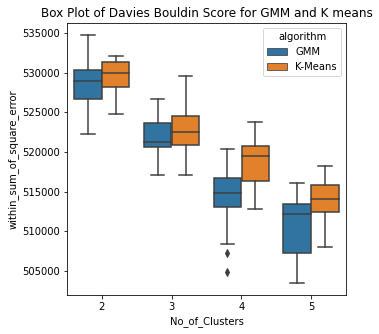

In [411]:
import seaborn as sns
expectation_maximization_statistics_without_updation_df['algorithm']='GMM'
error_values_kmeans_same_centroid_df['algorithm']='K-Means'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_without_updation_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_same_centroid_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='within_sum_of_square_error', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['K-Means','GMM'])],ax=ax);
plt.title('Box Plot of Davies Bouldin Score for GMM and K means')
plt.show()

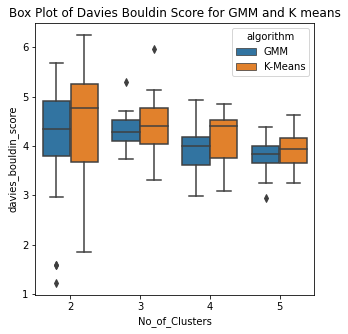

In [410]:
import seaborn as sns
expectation_maximization_statistics_without_updation_df['algorithm']='GMM'
error_values_kmeans_same_centroid_df['algorithm']='K-Means'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_without_updation_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_same_centroid_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='davies_bouldin_score', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['K-Means','GMM'])],ax=ax);
plt.title('Box Plot of Davies Bouldin Score for GMM and K means')
plt.show()

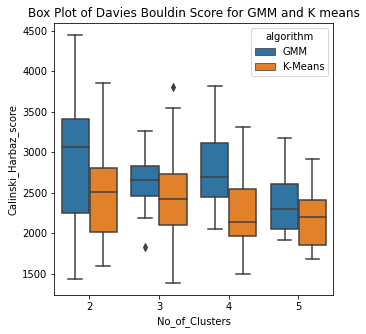

In [412]:
import seaborn as sns
expectation_maximization_statistics_without_updation_df['algorithm']='GMM'
error_values_kmeans_same_centroid_df['algorithm']='K-Means'
comparison_df=pd.DataFrame()
comparison_df=pd.concat([expectation_maximization_statistics_without_updation_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']],
error_values_kmeans_same_centroid_df[['algorithm','No_of_Clusters','within_sum_of_square_error','Calinski_Harbaz_score','davies_bouldin_score']]
],ignore_index=True )
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='No_of_Clusters', y='Calinski_Harbaz_score', hue='algorithm',
data=comparison_df[comparison_df['algorithm'].isin (['K-Means','GMM'])],ax=ax);
plt.title('Box Plot of Davies Bouldin Score for GMM and K means')
plt.show()